In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [8]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
X.shape

(4715, 25, 4)

In [9]:
v = X.reshape(X.shape[0],25, 4)
v[0]

array([[1.        , 1.        , 1.        , 1.        ],
       [0.79310329, 0.95162699, 0.79999987, 0.83557722],
       [0.68965526, 0.89289734, 0.81951214, 0.76058483],
       [0.55172434, 0.81947147, 0.22857217, 0.59494365],
       [0.58620658, 0.76327469, 0.28571412, 0.69826378],
       [0.65517237, 0.7275894 , 0.40000021, 0.75826988],
       [0.75862039, 0.7151928 , 0.59259233, 0.86506244],
       [0.58620658, 0.67503889, 0.29629617, 0.7693573 ],
       [0.55172434, 0.6351297 , 0.25600094, 0.71489491],
       [0.62068947, 0.61322611, 0.38400018, 0.75826988],
       [0.44827566, 0.56502783, 0.12799925, 0.62966799],
       [0.48275855, 0.53017758, 0.25263095, 0.65854401],
       [0.27586184, 0.46509152, 0.06956544, 0.53000305],
       [0.20689671, 0.39815298, 0.17777838, 0.34133415],
       [0.13793092, 0.32964685, 0.12307735, 0.19043558],
       [0.10344803, 0.2657472 , 0.06400023, 0.04843131],
       [0.20689671, 0.22947701, 0.30769244, 0.10886384],
       [0.06896513, 0.17505519,

In [10]:
y = labels
y = np.array(y)
y.shape

(4715,)

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [13]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [53]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 33ms/step - loss: 0.2891 - accuracy: 0.5501 - mse: 0.4566 - weighted_accuracy: 0.3225 - weighted_mse: 0.5394 - val_loss: 0.2985 - val_accuracy: 0.0445 - val_mse: 0.3565 - val_weighted_accuracy: 0.0445 - val_weighted_mse: 0.3565
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2118 - accuracy: 0.3834 - mse: 0.8121 - weighted_accuracy: 0.4287 - weighted_mse: 0.8009 - val_loss: 0.2882 - val_accuracy: 0.0456 - val_mse: 0.3829 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.3829
Epoch 3/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1926 - accuracy: 0.3653 - mse: 1.0235 - weighted_accuracy: 0.4740 - weighted_mse: 1.0100 - val_loss: 0.2768 - val_accuracy: 0.0456 - val_mse: 0.4172 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.4172
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1844 - accuracy: 0.3669 - mse: 1.1352 - weighted_accuracy: 0.5005 - weighte

30/30 [==============================] - 0s 7ms/step - loss: 0.1399 - accuracy: 0.4030 - mse: 1.5914 - weighted_accuracy: 0.6976 - weighted_mse: 1.5040 - val_loss: 0.1971 - val_accuracy: 0.3192 - val_mse: 1.6159 - val_weighted_accuracy: 0.3192 - val_weighted_mse: 1.6159
Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1383 - accuracy: 0.4205 - mse: 1.6034 - weighted_accuracy: 0.7078 - weighted_mse: 1.5266 - val_loss: 0.1881 - val_accuracy: 0.3754 - val_mse: 1.6581 - val_weighted_accuracy: 0.3754 - val_weighted_mse: 1.6581
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1370 - accuracy: 0.4250 - mse: 1.6242 - weighted_accuracy: 0.7076 - weighted_mse: 1.5376 - val_loss: 0.1951 - val_accuracy: 0.3436 - val_mse: 1.6232 - val_weighted_accuracy: 0.3436 - val_weighted_mse: 1.6232
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1363 - accuracy: 0.4191 - mse: 1.6383 - weighted_accuracy: 0.7221 - weighted_mse: 1.5

Epoch 58/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1130 - accuracy: 0.5284 - mse: 2.0981 - weighted_accuracy: 0.7919 - weighted_mse: 2.0283 - val_loss: 0.1772 - val_accuracy: 0.5090 - val_mse: 2.2095 - val_weighted_accuracy: 0.5090 - val_weighted_mse: 2.2095
Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1135 - accuracy: 0.5949 - mse: 2.1059 - weighted_accuracy: 0.8033 - weighted_mse: 2.0874 - val_loss: 0.2073 - val_accuracy: 0.4168 - val_mse: 2.1522 - val_weighted_accuracy: 0.4168 - val_weighted_mse: 2.1522
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1115 - accuracy: 0.5819 - mse: 2.1270 - weighted_accuracy: 0.8078 - weighted_mse: 2.0971 - val_loss: 0.1812 - val_accuracy: 0.5090 - val_mse: 2.2795 - val_weighted_accuracy: 0.5090 - val_weighted_mse: 2.2795
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1105 - accuracy: 0.5559 - mse: 2.1512 - weighted_accuracy: 0.8131 - weig

Epoch 87/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0887 - accuracy: 0.7017 - mse: 2.7808 - weighted_accuracy: 0.8851 - weighted_mse: 2.8540 - val_loss: 0.1833 - val_accuracy: 0.5811 - val_mse: 3.0554 - val_weighted_accuracy: 0.5811 - val_weighted_mse: 3.0554
Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0884 - accuracy: 0.6837 - mse: 2.8262 - weighted_accuracy: 0.8711 - weighted_mse: 2.8733 - val_loss: 0.1780 - val_accuracy: 0.5992 - val_mse: 2.9199 - val_weighted_accuracy: 0.5992 - val_weighted_mse: 2.9199
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0904 - accuracy: 0.6925 - mse: 2.8182 - weighted_accuracy: 0.8706 - weighted_mse: 2.8850 - val_loss: 0.2161 - val_accuracy: 0.4910 - val_mse: 3.0656 - val_weighted_accuracy: 0.4910 - val_weighted_mse: 3.0656
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0871 - accuracy: 0.6967 - mse: 2.8573 - weighted_accuracy: 0.8796 - weig

Epoch 116/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0681 - accuracy: 0.7781 - mse: 3.8487 - weighted_accuracy: 0.9168 - weighted_mse: 3.9227 - val_loss: 0.1892 - val_accuracy: 0.6691 - val_mse: 4.5262 - val_weighted_accuracy: 0.6691 - val_weighted_mse: 4.5262
Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0691 - accuracy: 0.7821 - mse: 3.8613 - weighted_accuracy: 0.9071 - weighted_mse: 3.9590 - val_loss: 0.2164 - val_accuracy: 0.6045 - val_mse: 4.4341 - val_weighted_accuracy: 0.6045 - val_weighted_mse: 4.4341
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0673 - accuracy: 0.7898 - mse: 3.9394 - weighted_accuracy: 0.9137 - weighted_mse: 3.9890 - val_loss: 0.1975 - val_accuracy: 0.6278 - val_mse: 4.2983 - val_weighted_accuracy: 0.6278 - val_weighted_mse: 4.2983
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0681 - accuracy: 0.7850 - mse: 4.0183 - weighted_accuracy: 0.9157 - 

Epoch 145/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0547 - accuracy: 0.8324 - mse: 5.2019 - weighted_accuracy: 0.9330 - weighted_mse: 5.2504 - val_loss: 0.2036 - val_accuracy: 0.6946 - val_mse: 5.6196 - val_weighted_accuracy: 0.6946 - val_weighted_mse: 5.6196
Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0538 - accuracy: 0.8521 - mse: 5.3070 - weighted_accuracy: 0.9402 - weighted_mse: 5.2982 - val_loss: 0.2230 - val_accuracy: 0.6554 - val_mse: 5.2335 - val_weighted_accuracy: 0.6554 - val_weighted_mse: 5.2335
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0558 - accuracy: 0.8192 - mse: 5.2214 - weighted_accuracy: 0.9282 - weighted_mse: 5.2562 - val_loss: 0.2171 - val_accuracy: 0.6691 - val_mse: 5.6872 - val_weighted_accuracy: 0.6691 - val_weighted_mse: 5.6872
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0551 - accuracy: 0.8301 - mse: 5.2857 - weighted_accuracy: 0.9359 - 

Epoch 174/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0450 - accuracy: 0.8746 - mse: 6.7046 - weighted_accuracy: 0.9429 - weighted_mse: 6.5175 - val_loss: 0.2193 - val_accuracy: 0.7413 - val_mse: 6.9148 - val_weighted_accuracy: 0.7413 - val_weighted_mse: 6.9148
Epoch 175/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0465 - accuracy: 0.8592 - mse: 6.6162 - weighted_accuracy: 0.9410 - weighted_mse: 6.5480 - val_loss: 0.2404 - val_accuracy: 0.7010 - val_mse: 7.2288 - val_weighted_accuracy: 0.7010 - val_weighted_mse: 7.2288
Epoch 176/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0431 - accuracy: 0.8818 - mse: 6.7964 - weighted_accuracy: 0.9492 - weighted_mse: 6.5335 - val_loss: 0.2237 - val_accuracy: 0.7529 - val_mse: 7.7027 - val_weighted_accuracy: 0.7529 - val_weighted_mse: 7.7027
Epoch 177/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0419 - accuracy: 0.8783 - mse: 6.8771 - weighted_accuracy: 0.9517 - 

In [54]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.25126081705093384
Test accuracy: 0.7370095252990723


In [55]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.5534945  -4.0565157  -0.03949204]
 [-2.6806881  -4.536191    2.415076  ]
 [-1.5896428  -2.4597752   0.38341677]
 ...
 [-3.850472   -5.121317    2.513813  ]
 [-1.2039318  -3.52963     0.25277746]
 [-1.5230055  -1.8719256   0.5932775 ]]


Counter({2: 770, 1: 93, 0: 80})

In [56]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 857, 0: 43, 1: 43})

In [57]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 943
actual predicted buys: 3
actual buys but predicted sell: 2
actual buys but predicted hold: 38
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 41
actual holds but predicted buy: 89
actual holds but predicted sell: 77
actual predicted holds: 691
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 2.3255813953488373%
Percentage holds correct: 80.63010501750291%
actual buys: 43
actual sells: 43
actual holds: 857


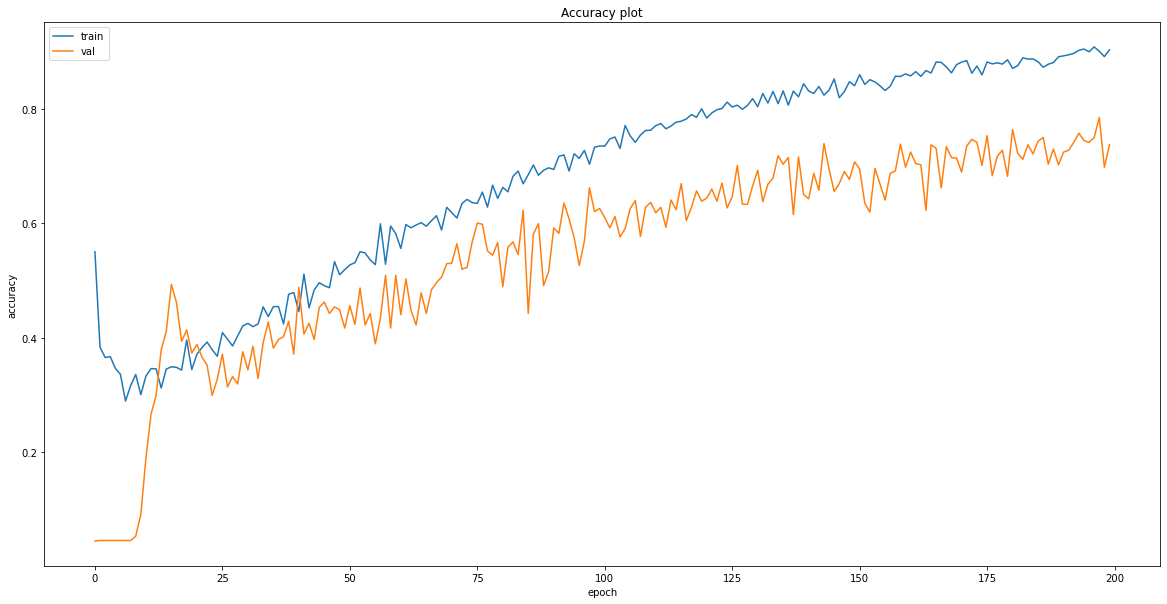

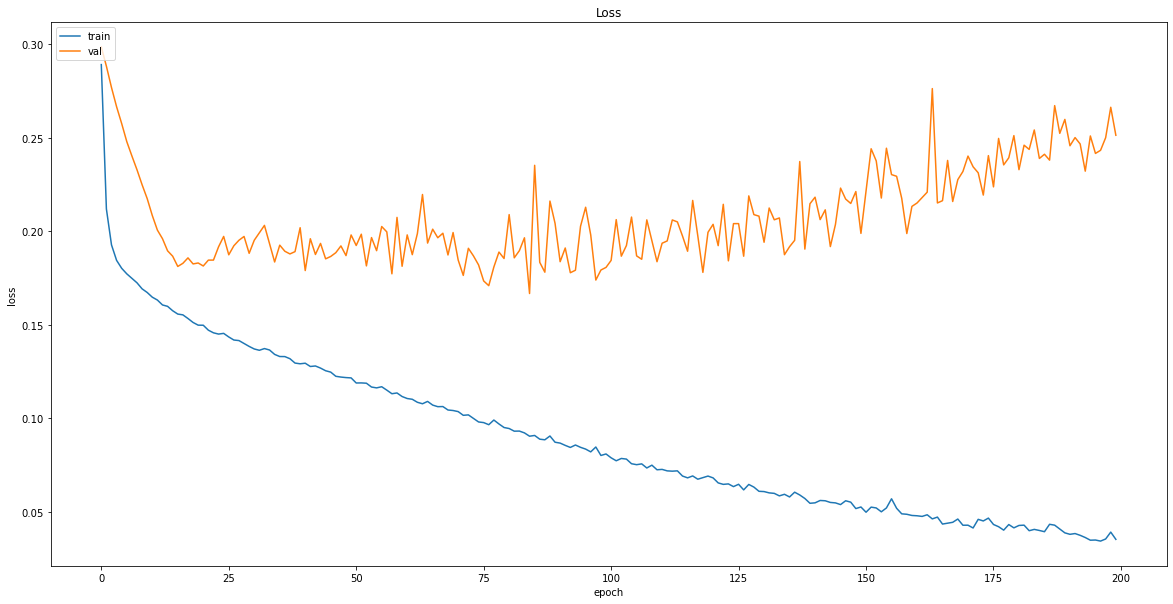

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
# Save model
model.save("models/{}".format('Singapore_Airlines_time_series_lstm_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/Singapore_Airlines_time_series_lstm_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [60]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-07,9.34,9.503724,-76.190390,-86008167.0,2.0
2018-12-10,9.43,9.492382,-61.904654,-83713267.0,1.0
2018-12-11,9.29,9.461246,-84.126926,-84539167.0,2.0
2018-12-12,9.33,9.441054,-87.500043,-83479567.0,2.0
2018-12-13,9.54,9.456277,-50.000000,-80918667.0,2.0


In [61]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [62]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(218, 25, 4)

In [63]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [64]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2025 - accuracy: 0.7248 - mean_squared_error: 8.2144 - weighted_accuracy: 0.7248 - weighted_mean_squared_error: 8.2144
Test loss: 0.20245251059532166
Test accuracy: 0.7247706651687622


In [65]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 166, 1: 31, 0: 21})

In [66]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [67]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-67-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-67-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-67-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,9.71,9.662247,-15.151533,6464788.0,2.0,2,2
2019-02-12,9.65,9.669594,-30.303065,5675088.0,2.0,2,2
2019-02-13,9.73,9.666579,-48.484962,4337188.0,2.0,2,2
2019-02-14,9.87,9.676336,-32.000351,5826588.0,2.0,2,2
2019-02-15,9.76,9.706131,-6.250130,8384988.0,2.0,2,2


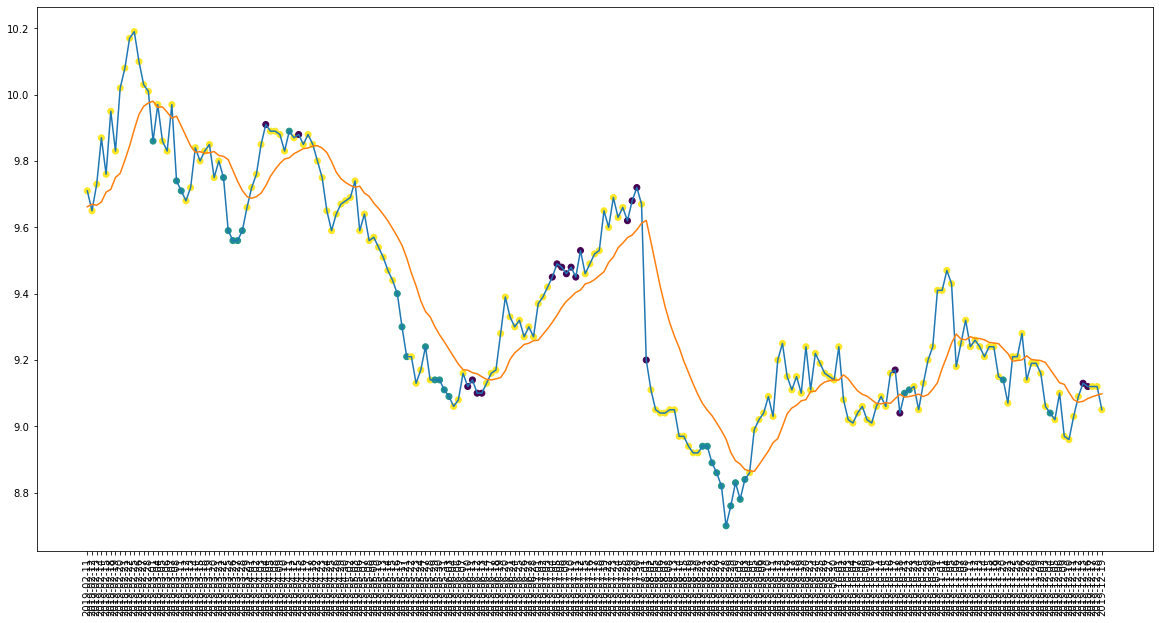

In [68]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [69]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 29
actual holds but predicted sell: 18
actual predicted holds: 153
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 76.5%
actual buys: 9
actual sells: 9
actual holds: 200


In [70]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 58.064516129032256%
Percentage sells correct: 61.904761904761905%
Percentage holds correct: 82.42424242424242%


In [71]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 58.064516129032256%
Percentage sells correct: 61.904761904761905%
Percentage holds correct: 82.42424242424242%


In [72]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $9.859999656677246
Shares owned at the moment: 1011
Cash capital at the moment: $4.1270830538269365


Stop Loss Activated!

Share price: $9.59000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9672.954639395952


Share price: $9.59000015258789
Shares owned at the moment: 1005
Cash capital at the moment: $8.50012312340732


Stop Loss Activated!

Share price: $9.300000190734863
Shares owned at the moment: 0
Cash capital at the moment: $9329.297439284801


Share price: $9.300000190734863
Shares owned at the moment: 1000
Cash capital at the moment: $3.722248025416775


Stop Loss Activated!

Share price: $9.039999961853027
Shares owned at the moment: 0
Cash capital at the moment: $9018.862209983348


Share price: $8.9399995803833
Shares owned at the moment: 1006
Cash capital at the moment: $0.4901232786178298




Capital at the end of test period: $9079.753489630222
profit gained: -9.202465103697778%


In [73]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


### Recession

In [82]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-09,9.10,9.126578,-59.999746,-5072299.0,2.0
2019-12-10,8.97,9.102489,-100.000000,-6511999.0,1.0
2019-12-11,8.96,9.080568,-94.117515,-8044399.0,2.0
2019-12-12,9.03,9.072788,-73.529379,-6794899.0,2.0
2019-12-13,9.09,9.075436,-55.882204,-5765899.0,0.0


In [83]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [84]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(215, 25, 4)

In [85]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [86]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.3006 - accuracy: 0.6651 - mean_squared_error: 8.1967 - weighted_accuracy: 0.6651 - weighted_mean_squared_error: 8.1967
Test loss: 0.30064237117767334
Test accuracy: 0.6651162505149841


In [87]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 153, 1: 42, 0: 20})

In [88]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [89]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-89-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-89-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-89-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,8.64,8.623953,-86.440694,-2356000.0,2.0,2,2
2020-02-13,8.59,8.626421,-61.224363,-575600.0,2.0,2,2
2020-02-14,8.62,8.620818,-64.102508,-2132700.0,2.0,2,2
2020-02-17,8.66,8.620692,-45.161340,-798700.0,2.0,2,2
2020-02-18,8.51,8.626740,-32.258144,341600.0,2.0,2,2


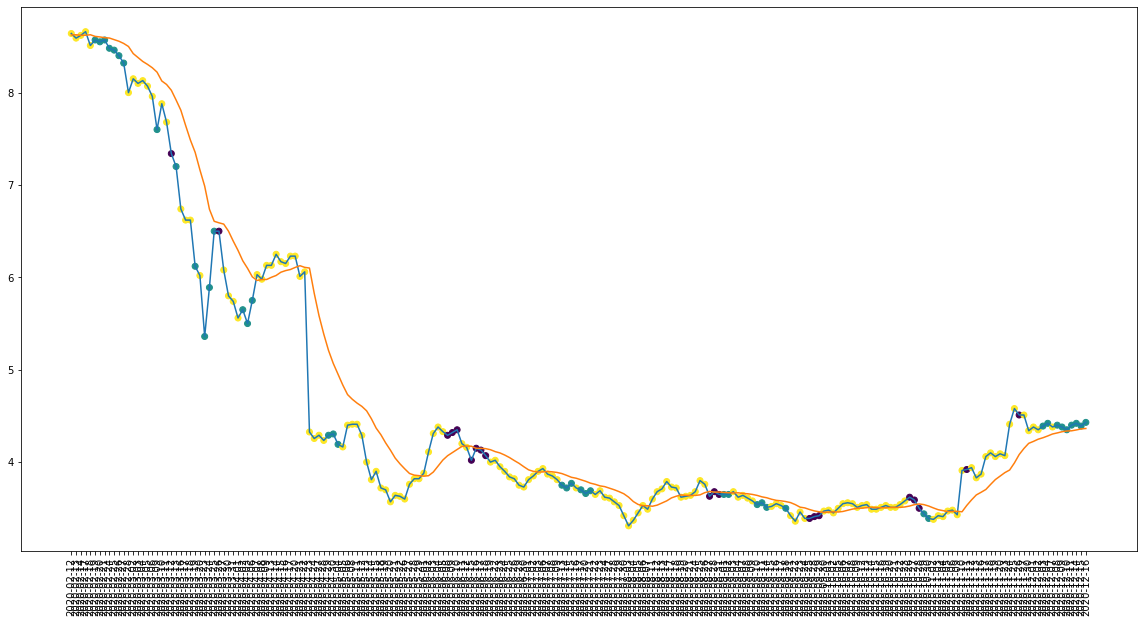

In [90]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [91]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 39
actual holds but predicted sell: 19
actual predicted holds: 140
Percentage buys correct: 25.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 70.70707070707071%
actual buys: 8
actual sells: 9
actual holds: 198


In [92]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 40.476190476190474%
Percentage sells correct: 55.0%
Percentage holds correct: 85.52631578947368%


In [93]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.569999694824219
Shares owned at the moment: 1163
Cash capital at the moment: $5.681353395460974


Stop Loss Activated!

Share price: $8.319999694824219
Shares owned at the moment: 0
Cash capital at the moment: $9655.231559452055


Share price: $8.319999694824219
Shares owned at the moment: 1157
Cash capital at the moment: $2.5197535114275524


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9233.065753511428


Share price: $7.599999904632567
Shares owned at the moment: 1211
Cash capital at the moment: $4.155969318986536


Stop Loss Activated!

Share price: $7.3400001525878915
Shares owned at the moment: 0
Cash capital at the moment: $8868.452118594767


Share price: $7.199999809265138
Shares owned at the moment: 1228
Cash capital at the moment: $2.537953461289362


Stop Loss Activated!

Share price: $6.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $8256.496693167328


Share price: $6.11999988

In [94]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


### OCBC Bank

In [322]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


In [323]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.793788,7.018572,-90.000010,-1965914.0,2.0
2000-01-24,6.890842,6.998922,-77.777802,6276910.0,2.0
2000-01-25,6.793788,6.967363,-85.714286,-511055.0,2.0
2000-01-26,6.745261,6.933193,-86.666549,-7435027.0,2.0
2000-01-27,6.890842,6.926678,-66.666601,-3725757.0,2.0


In [324]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [325]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
X.shape

(4779, 25, 4)

In [326]:
y = labels
y = np.array(y)

In [327]:
X[0]

array([[0.72222253, 0.99588343, 0.11538448, 0.78598501],
       [0.77777802, 0.97720387, 0.25640994, 0.86837769],
       [0.72222253, 0.9472047 , 0.16483514, 0.80052732],
       [0.69444491, 0.91472414, 0.15384749, 0.73131746],
       [0.77777802, 0.90853062, 0.38461608, 0.76839417],
       [0.97222239, 0.9529668 , 0.92307739, 0.91056274],
       [1.        , 0.99766329, 1.        , 1.        ],
       [0.8611114 , 1.        , 0.61538543, 0.87917113],
       [0.72222253, 0.96649374, 0.2307701 , 0.82957073],
       [0.77777802, 0.95233566, 0.38461608, 0.8828788 ],
       [0.66666703, 0.911969  , 0.07692412, 0.78730329],
       [0.72222253, 0.89200597, 0.24725358, 0.81313339],
       [0.72222253, 0.87511417, 0.24725358, 0.81313339],
       [0.63888887, 0.83953094, 0.        , 0.72204828],
       [0.44444451, 0.7597452 , 0.05244724, 0.59256818],
       [0.41666689, 0.68513754, 0.17751463, 0.46654857],
       [0.33333352, 0.60071788, 0.08546999, 0.34716157],
       [0.41666689, 0.55057596,

In [328]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [329]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [330]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [331]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [332]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 33ms/step - loss: 0.2835 - accuracy: 0.5773 - mse: 0.4423 - weighted_accuracy: 0.3431 - weighted_mse: 0.5343 - val_loss: 0.2988 - val_accuracy: 0.0418 - val_mse: 0.3554 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3554
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2104 - accuracy: 0.3604 - mse: 0.7926 - weighted_accuracy: 0.4181 - weighted_mse: 0.7836 - val_loss: 0.2894 - val_accuracy: 0.0418 - val_mse: 0.3837 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3837
Epoch 3/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1900 - accuracy: 0.3272 - mse: 1.0256 - weighted_accuracy: 0.4932 - weighted_mse: 1.0024 - val_loss: 0.2792 - val_accuracy: 0.0418 - val_mse: 0.4215 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.4215
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1822 - accuracy: 0.3034 - mse: 1.1564 - weighted_accuracy: 0.5082 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1372 - accuracy: 0.4470 - mse: 1.6324 - weighted_accuracy: 0.7235 - weighted_mse: 1.5569 - val_loss: 0.1965 - val_accuracy: 0.3598 - val_mse: 1.6020 - val_weighted_accuracy: 0.3598 - val_weighted_mse: 1.6020
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1358 - accuracy: 0.4159 - mse: 1.6603 - weighted_accuracy: 0.7291 - weighted_mse: 1.5695 - val_loss: 0.2006 - val_accuracy: 0.3536 - val_mse: 1.7626 - val_weighted_accuracy: 0.3536 - val_weighted_mse: 1.7626
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1343 - accuracy: 0.4397 - mse: 1.6949 - weighted_accuracy: 0.7283 - weighted_mse: 1.6206 - val_loss: 0.1978 - val_accuracy: 0.3389 - val_mse: 1.7545 - val_weighted_accuracy: 0.3389 - val_weighted_mse: 1.7545
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1331 - accuracy: 0.4358 - mse: 1.7104 - weighted_accuracy: 0.7303 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1153 - accuracy: 0.5634 - mse: 2.1779 - weighted_accuracy: 0.7950 - weighted_mse: 2.1429 - val_loss: 0.1733 - val_accuracy: 0.5178 - val_mse: 2.3538 - val_weighted_accuracy: 0.5178 - val_weighted_mse: 2.3538
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1123 - accuracy: 0.5650 - mse: 2.1989 - weighted_accuracy: 0.7982 - weighted_mse: 2.1815 - val_loss: 0.1752 - val_accuracy: 0.5324 - val_mse: 2.3288 - val_weighted_accuracy: 0.5324 - val_weighted_mse: 2.3288
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1108 - accuracy: 0.5538 - mse: 2.2375 - weighted_accuracy: 0.7939 - weighted_mse: 2.2263 - val_loss: 0.1691 - val_accuracy: 0.5481 - val_mse: 2.5092 - val_weighted_accuracy: 0.5481 - val_weighted_mse: 2.5092
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1102 - accuracy: 0.6029 - mse: 2.2496 - weighted_accuracy: 0.8101 - weig

Epoch 88/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0909 - accuracy: 0.6673 - mse: 2.9621 - weighted_accuracy: 0.8543 - weighted_mse: 2.9900 - val_loss: 0.1808 - val_accuracy: 0.5565 - val_mse: 2.9018 - val_weighted_accuracy: 0.5565 - val_weighted_mse: 2.9018
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0911 - accuracy: 0.6673 - mse: 2.9308 - weighted_accuracy: 0.8654 - weighted_mse: 2.9527 - val_loss: 0.1778 - val_accuracy: 0.5659 - val_mse: 2.9930 - val_weighted_accuracy: 0.5659 - val_weighted_mse: 2.9930
Epoch 90/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0895 - accuracy: 0.6864 - mse: 2.9745 - weighted_accuracy: 0.8665 - weighted_mse: 3.0263 - val_loss: 0.1855 - val_accuracy: 0.5659 - val_mse: 3.0406 - val_weighted_accuracy: 0.5659 - val_weighted_mse: 3.0406
Epoch 91/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0904 - accuracy: 0.6736 - mse: 2.9974 - weighted_accuracy: 0.8618 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0740 - accuracy: 0.7536 - mse: 3.8817 - weighted_accuracy: 0.8986 - weighted_mse: 3.8959 - val_loss: 0.1812 - val_accuracy: 0.6287 - val_mse: 3.8905 - val_weighted_accuracy: 0.6287 - val_weighted_mse: 3.8905
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0736 - accuracy: 0.7539 - mse: 3.9670 - weighted_accuracy: 0.8985 - weighted_mse: 3.9608 - val_loss: 0.1809 - val_accuracy: 0.6328 - val_mse: 3.9317 - val_weighted_accuracy: 0.6328 - val_weighted_mse: 3.9317
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0764 - accuracy: 0.7319 - mse: 4.0075 - weighted_accuracy: 0.8869 - weighted_mse: 3.9795 - val_loss: 0.1938 - val_accuracy: 0.6182 - val_mse: 4.3549 - val_weighted_accuracy: 0.6182 - val_weighted_mse: 4.3549
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0722 - accuracy: 0.7502 - mse: 4.0806 - weighted_accuracy: 0.8972 - 

Epoch 146/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0572 - accuracy: 0.8159 - mse: 5.3293 - weighted_accuracy: 0.9253 - weighted_mse: 5.1362 - val_loss: 0.1895 - val_accuracy: 0.7071 - val_mse: 5.5821 - val_weighted_accuracy: 0.7071 - val_weighted_mse: 5.5821
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0586 - accuracy: 0.8135 - mse: 5.3369 - weighted_accuracy: 0.9280 - weighted_mse: 5.1641 - val_loss: 0.1785 - val_accuracy: 0.7385 - val_mse: 5.9214 - val_weighted_accuracy: 0.7385 - val_weighted_mse: 5.9214
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0566 - accuracy: 0.8177 - mse: 5.4818 - weighted_accuracy: 0.9260 - weighted_mse: 5.2516 - val_loss: 0.1745 - val_accuracy: 0.7490 - val_mse: 6.0394 - val_weighted_accuracy: 0.7490 - val_weighted_mse: 6.0394
Epoch 149/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0576 - accuracy: 0.8140 - mse: 5.5634 - weighted_accuracy: 0.9263 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0463 - accuracy: 0.8632 - mse: 7.1301 - weighted_accuracy: 0.9462 - weighted_mse: 6.5883 - val_loss: 0.2351 - val_accuracy: 0.6872 - val_mse: 7.5994 - val_weighted_accuracy: 0.6872 - val_weighted_mse: 7.5994
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0475 - accuracy: 0.8567 - mse: 7.2170 - weighted_accuracy: 0.9419 - weighted_mse: 6.6819 - val_loss: 0.2021 - val_accuracy: 0.7469 - val_mse: 7.9950 - val_weighted_accuracy: 0.7469 - val_weighted_mse: 7.9950
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0484 - accuracy: 0.8616 - mse: 7.2895 - weighted_accuracy: 0.9458 - weighted_mse: 6.7424 - val_loss: 0.2182 - val_accuracy: 0.7061 - val_mse: 7.6086 - val_weighted_accuracy: 0.7061 - val_weighted_mse: 7.6086
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0457 - accuracy: 0.8595 - mse: 7.3431 - weighted_accuracy: 0.9427 - 

In [333]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2218654453754425
Test accuracy: 0.7468619346618652


In [334]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.087311   -3.397236    1.1308788 ]
 [-2.9009187  -7.1680455   2.7830398 ]
 [-3.3647616  -0.7635565  -0.25979087]
 ...
 [-5.2417126  -0.06733851 -0.68967575]
 [-5.008805   -0.43595552 -0.46405566]
 [-2.885725   -4.631091    2.9493704 ]]


Counter({2: 773, 0: 89, 1: 94})

In [335]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 872, 0: 44, 1: 40})

In [336]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 956
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 34
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 37
actual holds but predicted buy: 87
actual holds but predicted sell: 83
actual predicted holds: 702
Percentage buys correct: 15.0%
Percentage sells correct: 13.636363636363637%
Percentage holds correct: 80.5045871559633%
actual buys: 40
actual sells: 44
actual holds: 872


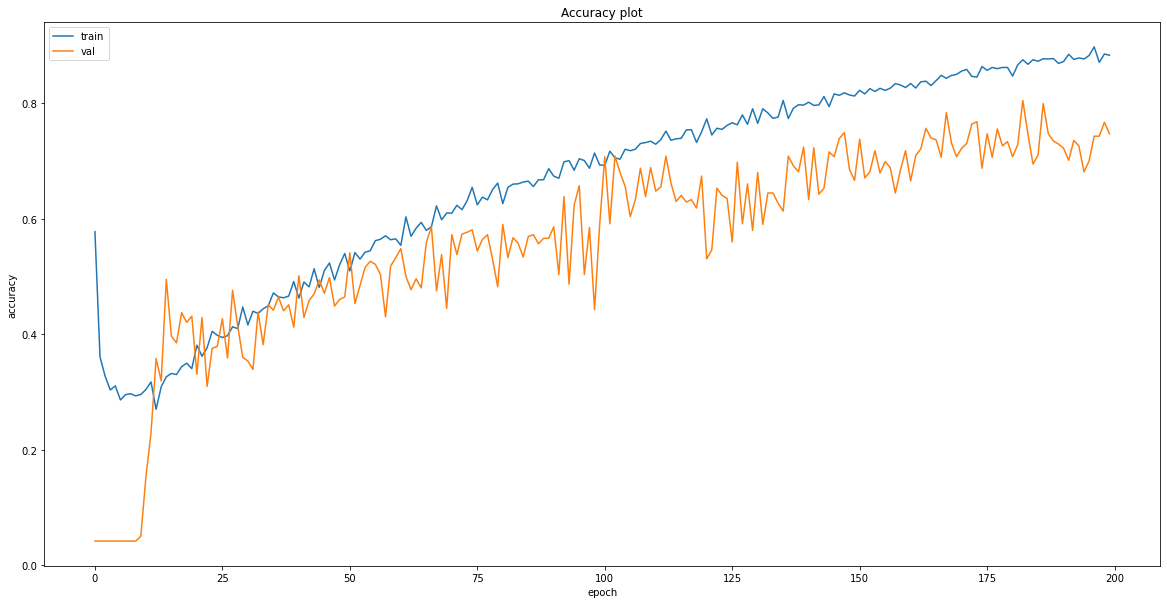

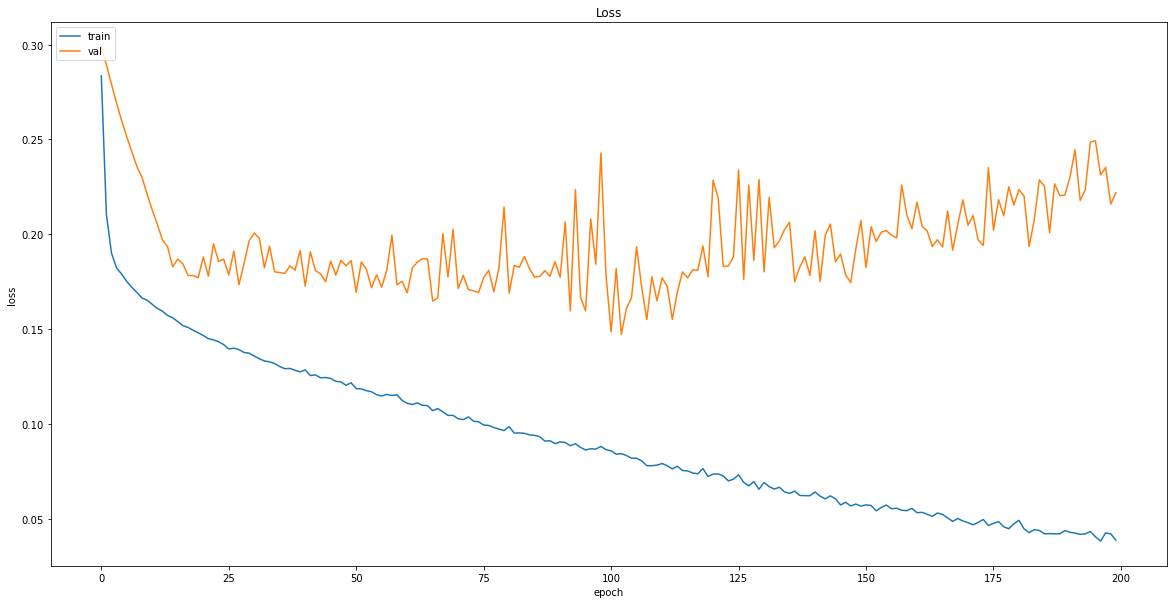

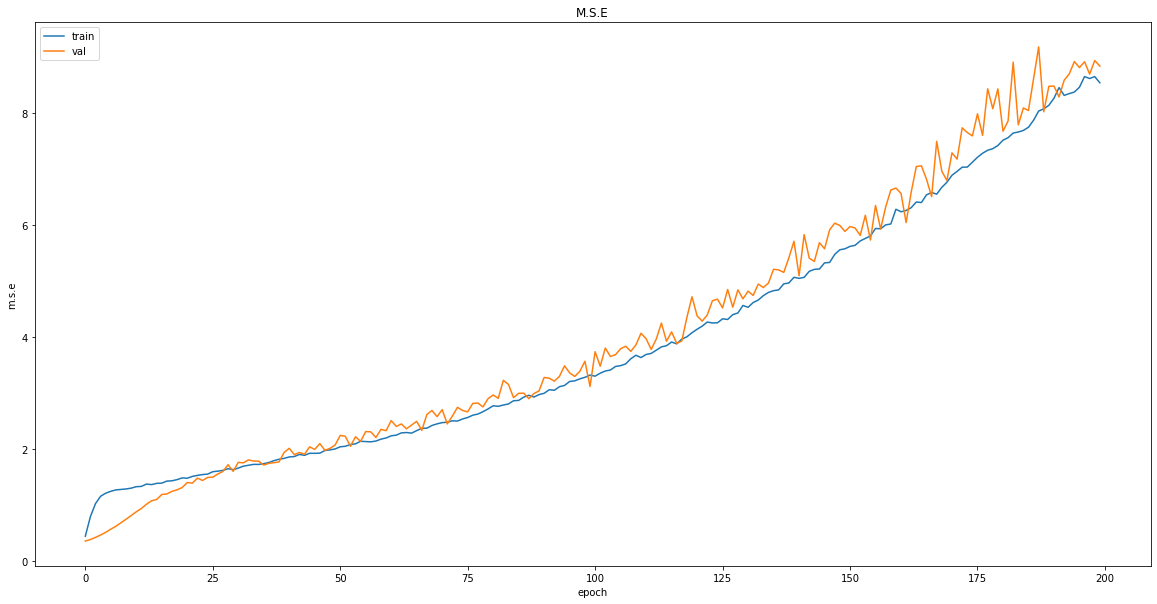

In [337]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [338]:
# Save model
model.save("models/{}".format('ocbc_time_series_lstm_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/ocbc_time_series_lstm_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [339]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-07,11.31,11.282011,-31.958699,451430629.0,2.0
2018-12-10,11.23,11.274010,-40.206210,447140929.0,2.0
2018-12-11,11.07,11.242623,-56.701035,443372229.0,1.0
2018-12-12,11.05,11.212989,-65.517215,438680229.0,2.0
2018-12-13,11.20,11.210991,-48.275877,443121729.0,2.0


In [340]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [341]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(218, 25, 4)

In [342]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [343]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1842 - accuracy: 0.7523 - mean_squared_error: 9.3842 - weighted_accuracy: 0.7523 - weighted_mean_squared_error: 9.3842
Test loss: 0.18418468534946442
Test accuracy: 0.752293586730957


In [344]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 171, 1: 23, 0: 24})

In [345]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [346]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-346-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-346-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-346-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,11.53,11.457507,-67.857228,17615658.0,2.0,2,2
2019-02-12,11.49,11.468659,-43.902530,20832858.0,2.0,2,2
2019-02-13,11.65,11.471942,-42.424356,17325458.0,2.0,2,2
2019-02-14,11.68,11.499336,-10.256417,22091358.0,2.0,2,2
2019-02-15,11.52,11.527130,-5.714153,24228358.0,2.0,2,2


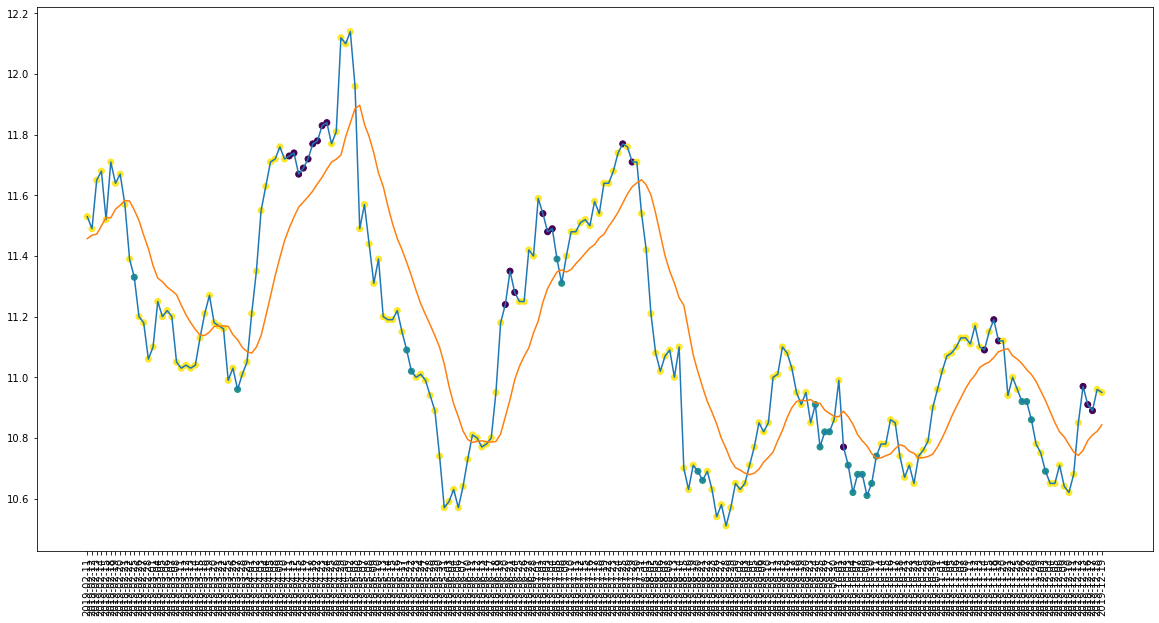

In [347]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

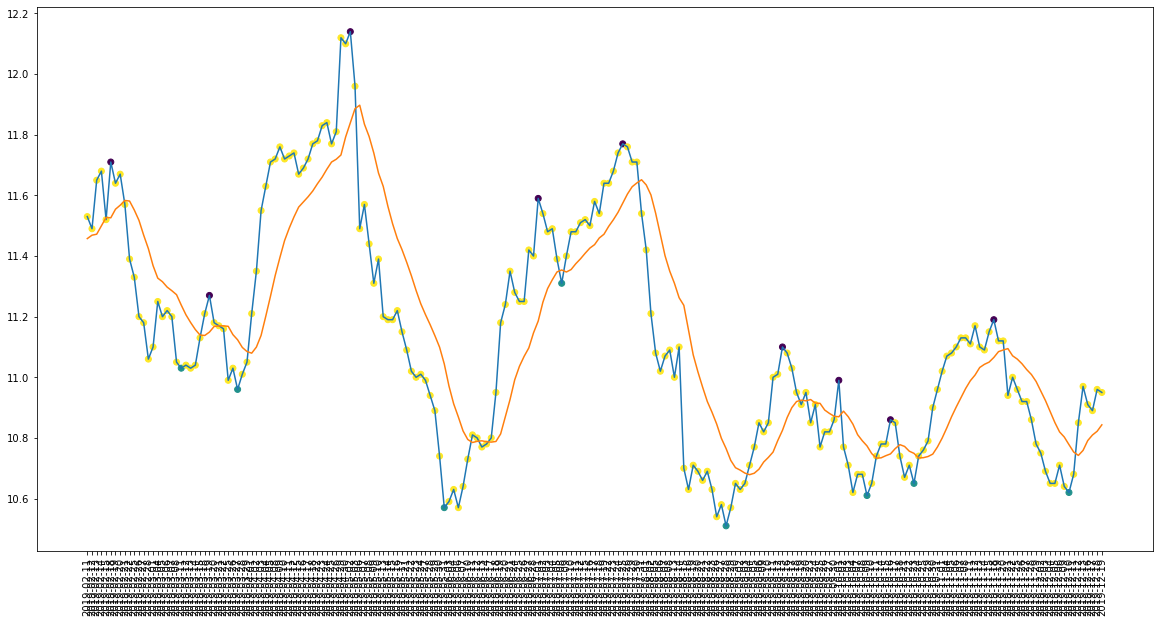

In [348]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [349]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 20
actual holds but predicted sell: 22
actual predicted holds: 159
Percentage buys correct: 37.5%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 79.1044776119403%
actual buys: 8
actual sells: 9
actual holds: 201


In [350]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 56.52173913043478%
Percentage sells correct: 70.83333333333333%
Percentage holds correct: 87.6470588235294%


In [351]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.329999923706055
Shares owned at the moment: 880
Cash capital at the moment: $2.1814673233020585


Stop Loss Activated!

Share price: $10.989999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9646.78546646118


Share price: $10.960000038146973
Shares owned at the moment: 877
Cash capital at the moment: $8.432652914283608


Price increase from previously bought: 6.732029814081741%
Share price: $11.729999542236328
Shares owned at the moment: 0
Cash capital at the moment: $10267.352425059555


Share price: $11.09000015258789
Shares owned at the moment: 923
Cash capital at the moment: $3.1330913336259982


Stop Loss Activated!

Share price: $10.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9888.892075656651


Share price: $11.390000343322756
Shares owned at the moment: 865
Cash capital at the moment: $9.447815365787392


Stop Loss Activated!

Share price: $11.020000457763672
Shares owned at the moment: 0
Cash capital at the 

In [352]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


### recession

In [353]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-09,10.71,10.802927,-75.438564,46900142.0,2.0
2019-12-10,10.64,10.777861,-87.272614,42802742.0,1.0
2019-12-11,10.62,10.753575,-90.196045,37577242.0,2.0
2019-12-12,10.68,10.742256,-78.431263,41151442.0,2.0
2019-12-13,10.85,10.758832,-45.097929,47717842.0,2.0


In [354]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [355]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(215, 25, 4)

In [356]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [357]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.3719 - accuracy: 0.7302 - mean_squared_error: 11.9901 - weighted_accuracy: 0.7302 - weighted_mean_squared_error: 11.9901
Test loss: 0.37190306186676025
Test accuracy: 0.7302325367927551


In [358]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 171, 0: 17, 1: 27})

In [359]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [360]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-360-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-360-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-360-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,11.02,10.890637,-80.357049,13333200.0,2.0,2,2
2020-02-13,11.05,10.910539,-32.075322,21593100.0,2.0,2,2
2020-02-14,11.06,10.931995,-15.217324,25962500.0,2.0,2,2
2020-02-17,11.01,10.951688,-13.043361,29610200.0,2.0,2,2
2020-02-18,10.97,10.960659,-23.912967,27996300.0,2.0,2,2


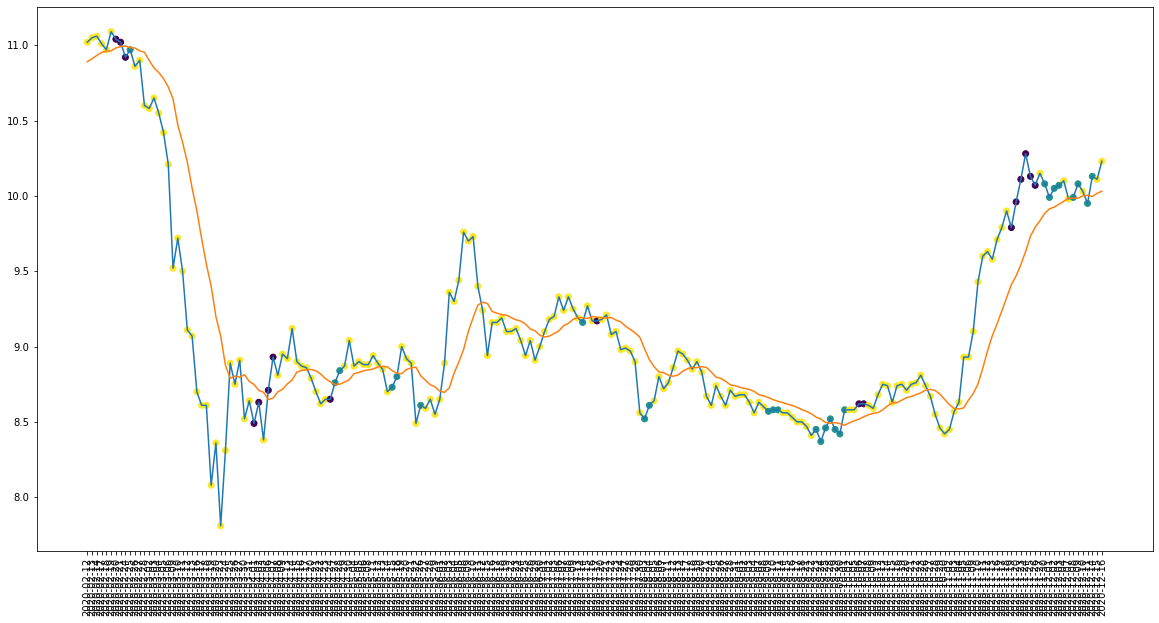

In [361]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

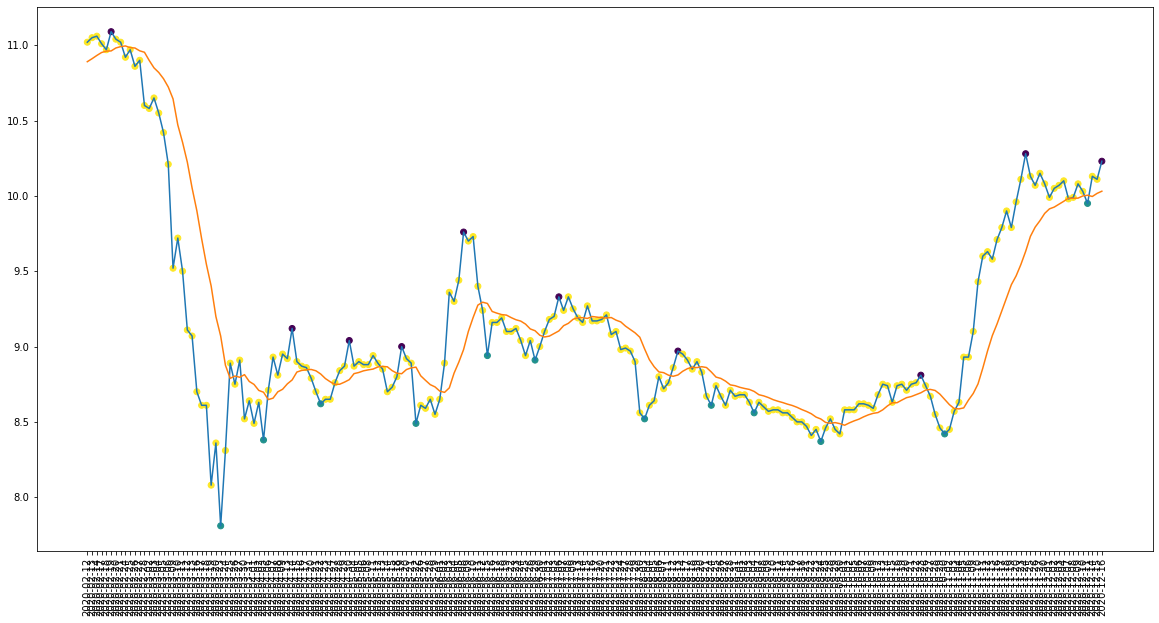

In [362]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [363]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 24
actual holds but predicted sell: 16
actual predicted holds: 153
Percentage buys correct: 25.0%
Percentage sells correct: 10.0%
Percentage holds correct: 79.27461139896373%
actual buys: 12
actual sells: 10
actual holds: 193


In [364]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 55.55555555555556%
Percentage sells correct: 47.05882352941177%
Percentage holds correct: 85.29411764705883%


In [365]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.970000267028807
Shares owned at the moment: 909
Cash capital at the moment: $0.8474991033090191


Stop Loss Activated!

Share price: $10.600000381469727
Shares owned at the moment: 0
Cash capital at the moment: $9609.750494905711


Share price: $8.760000228881836
Shares owned at the moment: 1093
Cash capital at the moment: $8.739874049902937


Stop Loss Activated!

Share price: $8.489999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9262.790807070018


Share price: $8.609999656677246
Shares owned at the moment: 1072
Cash capital at the moment: $7.488896124124949


Price increase from previously bought: 6.211987208772274%
Share price: $9.170000076293944
Shares owned at the moment: 0
Cash capital at the moment: $9810.695817686317


Share price: $8.520000457763674
Shares owned at the moment: 1148
Cash capital at the moment: $2.8376507284592662


Price increase from previously bought: 14.590971493354044%
Share price: $9.789999961853027
Shares owned at

In [366]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


## CNOOC Limited

In [367]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


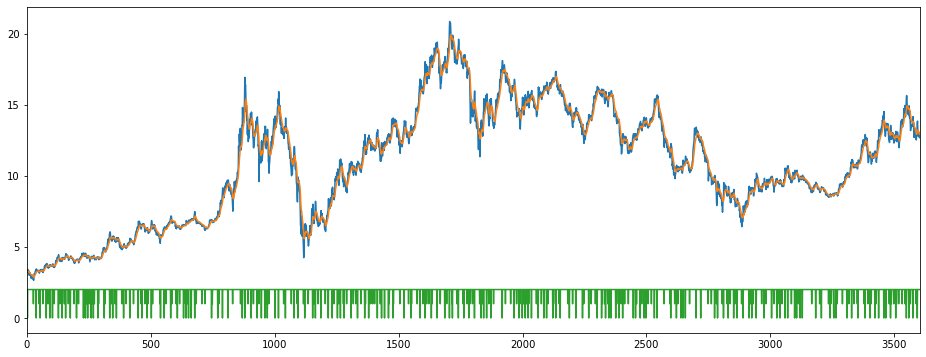

In [368]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [369]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2004-04-07,3.250,3.264699,-57.142857,31539206.0,2.0
2004-04-08,3.200,3.254745,-78.947368,-24878594.0,2.0
2004-04-13,3.250,3.254015,-52.631579,10937473.0,0.0
2004-04-14,3.375,3.272628,-10.416706,98972973.0,2.0
2004-04-15,3.275,3.272993,-52.083331,47190715.0,2.0


In [370]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

In [371]:
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
X.shape

(3580, 25, 4)

In [372]:
y = labels
y = np.array(y)

In [373]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [374]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [375]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [376]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [377]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
23/23 [==============================] - 1s 39ms/step - loss: 0.2917 - accuracy: 0.5457 - mse: 0.4210 - weighted_accuracy: 0.3433 - weighted_mse: 0.5041 - val_loss: 0.3016 - val_accuracy: 0.0489 - val_mse: 0.3512 - val_weighted_accuracy: 0.0489 - val_weighted_mse: 0.3512
Epoch 2/200
23/23 [==============================] - 0s 8ms/step - loss: 0.2171 - accuracy: 0.4145 - mse: 0.7009 - weighted_accuracy: 0.4160 - weighted_mse: 0.7039 - val_loss: 0.2935 - val_accuracy: 0.0447 - val_mse: 0.3718 - val_weighted_accuracy: 0.0447 - val_weighted_mse: 0.3718
Epoch 3/200
23/23 [==============================] - 0s 8ms/step - loss: 0.1963 - accuracy: 0.3568 - mse: 0.9242 - weighted_accuracy: 0.4450 - weighted_mse: 0.9084 - val_loss: 0.2859 - val_accuracy: 0.0447 - val_mse: 0.3992 - val_weighted_accuracy: 0.0447 - val_weighted_mse: 0.3992
Epoch 4/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1872 - accuracy: 0.3160 - mse: 1.0620 - weighted_accuracy: 0.4734 - weighte

Epoch 30/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1390 - accuracy: 0.3932 - mse: 1.5508 - weighted_accuracy: 0.7025 - weighted_mse: 1.4744 - val_loss: 0.1888 - val_accuracy: 0.3589 - val_mse: 1.4476 - val_weighted_accuracy: 0.3589 - val_weighted_mse: 1.4476
Epoch 31/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1375 - accuracy: 0.4239 - mse: 1.5638 - weighted_accuracy: 0.7140 - weighted_mse: 1.5005 - val_loss: 0.1849 - val_accuracy: 0.4008 - val_mse: 1.4018 - val_weighted_accuracy: 0.4008 - val_weighted_mse: 1.4018
Epoch 32/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1363 - accuracy: 0.4005 - mse: 1.5900 - weighted_accuracy: 0.7222 - weighted_mse: 1.5153 - val_loss: 0.1943 - val_accuracy: 0.3352 - val_mse: 1.5128 - val_weighted_accuracy: 0.3352 - val_weighted_mse: 1.5128
Epoch 33/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1344 - accuracy: 0.4249 - mse: 1.5942 - weighted_accuracy: 0.7334 - weig

23/23 [==============================] - 0s 7ms/step - loss: 0.1135 - accuracy: 0.5527 - mse: 1.9933 - weighted_accuracy: 0.8094 - weighted_mse: 1.9783 - val_loss: 0.1772 - val_accuracy: 0.4902 - val_mse: 2.0963 - val_weighted_accuracy: 0.4902 - val_weighted_mse: 2.0963
Epoch 59/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1160 - accuracy: 0.5405 - mse: 2.0201 - weighted_accuracy: 0.7904 - weighted_mse: 2.0045 - val_loss: 0.1765 - val_accuracy: 0.4902 - val_mse: 2.0400 - val_weighted_accuracy: 0.4902 - val_weighted_mse: 2.0400
Epoch 60/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1142 - accuracy: 0.5632 - mse: 2.0164 - weighted_accuracy: 0.7964 - weighted_mse: 2.0006 - val_loss: 0.1806 - val_accuracy: 0.4539 - val_mse: 2.0135 - val_weighted_accuracy: 0.4539 - val_weighted_mse: 2.0135
Epoch 61/200
23/23 [==============================] - 0s 8ms/step - loss: 0.1135 - accuracy: 0.5845 - mse: 2.0342 - weighted_accuracy: 0.7995 - weighted_mse: 2.0

23/23 [==============================] - 0s 7ms/step - loss: 0.0954 - accuracy: 0.6690 - mse: 2.4985 - weighted_accuracy: 0.8641 - weighted_mse: 2.5879 - val_loss: 0.1715 - val_accuracy: 0.5628 - val_mse: 2.5999 - val_weighted_accuracy: 0.5628 - val_weighted_mse: 2.5999
Epoch 87/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0965 - accuracy: 0.6484 - mse: 2.5644 - weighted_accuracy: 0.8517 - weighted_mse: 2.6270 - val_loss: 0.1804 - val_accuracy: 0.5461 - val_mse: 2.8378 - val_weighted_accuracy: 0.5461 - val_weighted_mse: 2.8378
Epoch 88/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0951 - accuracy: 0.6634 - mse: 2.5428 - weighted_accuracy: 0.8549 - weighted_mse: 2.6337 - val_loss: 0.1659 - val_accuracy: 0.5754 - val_mse: 2.6002 - val_weighted_accuracy: 0.5754 - val_weighted_mse: 2.6002
Epoch 89/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0935 - accuracy: 0.6819 - mse: 2.6045 - weighted_accuracy: 0.8664 - weighted_mse: 2.6

Epoch 115/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0786 - accuracy: 0.7521 - mse: 3.3074 - weighted_accuracy: 0.8922 - weighted_mse: 3.4746 - val_loss: 0.1639 - val_accuracy: 0.6466 - val_mse: 3.4778 - val_weighted_accuracy: 0.6466 - val_weighted_mse: 3.4778
Epoch 116/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0770 - accuracy: 0.7493 - mse: 3.3029 - weighted_accuracy: 0.8984 - weighted_mse: 3.4613 - val_loss: 0.1846 - val_accuracy: 0.5810 - val_mse: 3.4888 - val_weighted_accuracy: 0.5810 - val_weighted_mse: 3.4888
Epoch 117/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0773 - accuracy: 0.7371 - mse: 3.3256 - weighted_accuracy: 0.8963 - weighted_mse: 3.4302 - val_loss: 0.1538 - val_accuracy: 0.6885 - val_mse: 3.3774 - val_weighted_accuracy: 0.6885 - val_weighted_mse: 3.3774
Epoch 118/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0759 - accuracy: 0.7629 - mse: 3.3614 - weighted_accuracy: 0.9034 - 

23/23 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.7891 - mse: 4.2785 - weighted_accuracy: 0.9154 - weighted_mse: 4.4033 - val_loss: 0.1735 - val_accuracy: 0.6522 - val_mse: 4.6592 - val_weighted_accuracy: 0.6522 - val_weighted_mse: 4.6592
Epoch 144/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0625 - accuracy: 0.8122 - mse: 4.2616 - weighted_accuracy: 0.9287 - weighted_mse: 4.3884 - val_loss: 0.1690 - val_accuracy: 0.6606 - val_mse: 4.7320 - val_weighted_accuracy: 0.6606 - val_weighted_mse: 4.7320
Epoch 145/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0601 - accuracy: 0.8184 - mse: 4.3051 - weighted_accuracy: 0.9334 - weighted_mse: 4.4769 - val_loss: 0.1638 - val_accuracy: 0.7025 - val_mse: 4.7727 - val_weighted_accuracy: 0.7025 - val_weighted_mse: 4.7727
Epoch 146/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0597 - accuracy: 0.8258 - mse: 4.4032 - weighted_accuracy: 0.9312 - weighted_mse: 

Epoch 172/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0492 - accuracy: 0.8541 - mse: 5.5770 - weighted_accuracy: 0.9441 - weighted_mse: 5.6484 - val_loss: 0.1768 - val_accuracy: 0.7151 - val_mse: 5.7449 - val_weighted_accuracy: 0.7151 - val_weighted_mse: 5.7449
Epoch 173/200
23/23 [==============================] - 0s 8ms/step - loss: 0.0464 - accuracy: 0.8551 - mse: 5.6341 - weighted_accuracy: 0.9468 - weighted_mse: 5.6733 - val_loss: 0.1756 - val_accuracy: 0.7542 - val_mse: 5.9928 - val_weighted_accuracy: 0.7542 - val_weighted_mse: 5.9928
Epoch 174/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0488 - accuracy: 0.8610 - mse: 5.6418 - weighted_accuracy: 0.9442 - weighted_mse: 5.7049 - val_loss: 0.1952 - val_accuracy: 0.7011 - val_mse: 5.9139 - val_weighted_accuracy: 0.7011 - val_weighted_mse: 5.9139
Epoch 175/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0489 - accuracy: 0.8603 - mse: 5.7800 - weighted_accuracy: 0.9415 - 

In [378]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20783080160617828
Test accuracy: 0.7206704020500183


In [379]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.6402342  -1.125576   -0.32286105]
 [-3.173401   -2.4390585   0.4795533 ]
 [-2.5808237  -1.4285733   0.257585  ]
 ...
 [-2.5873938  -7.7335114   1.5408633 ]
 [-2.9900322  -2.7822063   1.43434   ]
 [-1.6278076  -3.1815455   1.0932953 ]]


Counter({2: 576, 1: 51, 0: 89})

In [380]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 651, 1: 32, 0: 33})

In [381]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 716
actual predicted buys: 0
actual buys but predicted sell: 2
actual buys but predicted hold: 30
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 31
actual holds but predicted buy: 50
actual holds but predicted sell: 86
actual predicted holds: 515
Percentage buys correct: 0.0%
Percentage sells correct: 3.0303030303030303%
Percentage holds correct: 79.10906298003073%
actual buys: 32
actual sells: 33
actual holds: 651


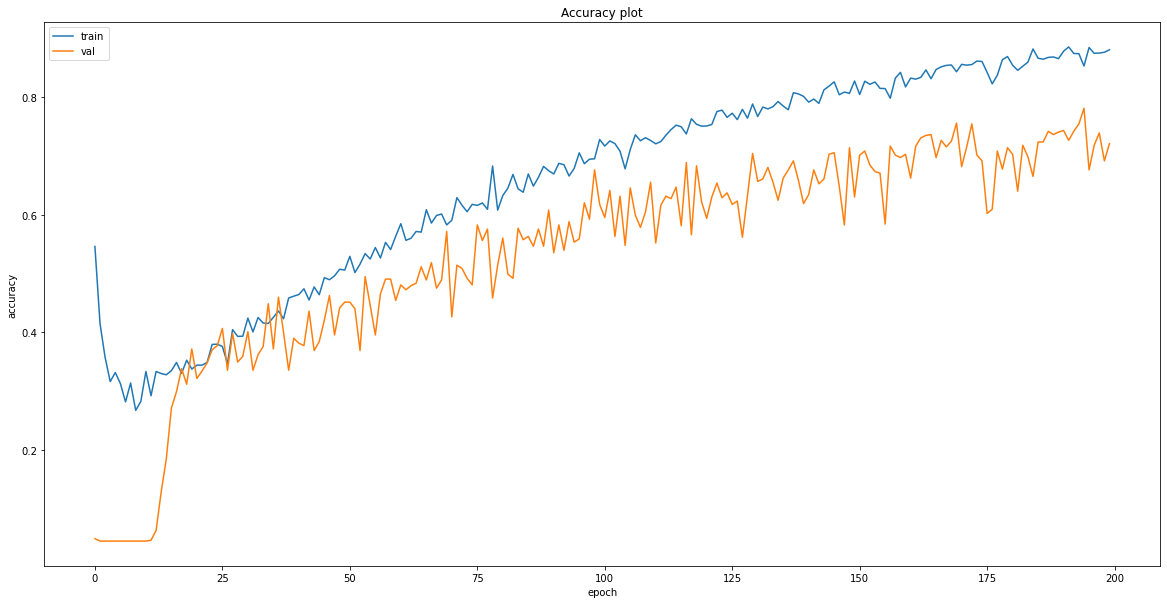

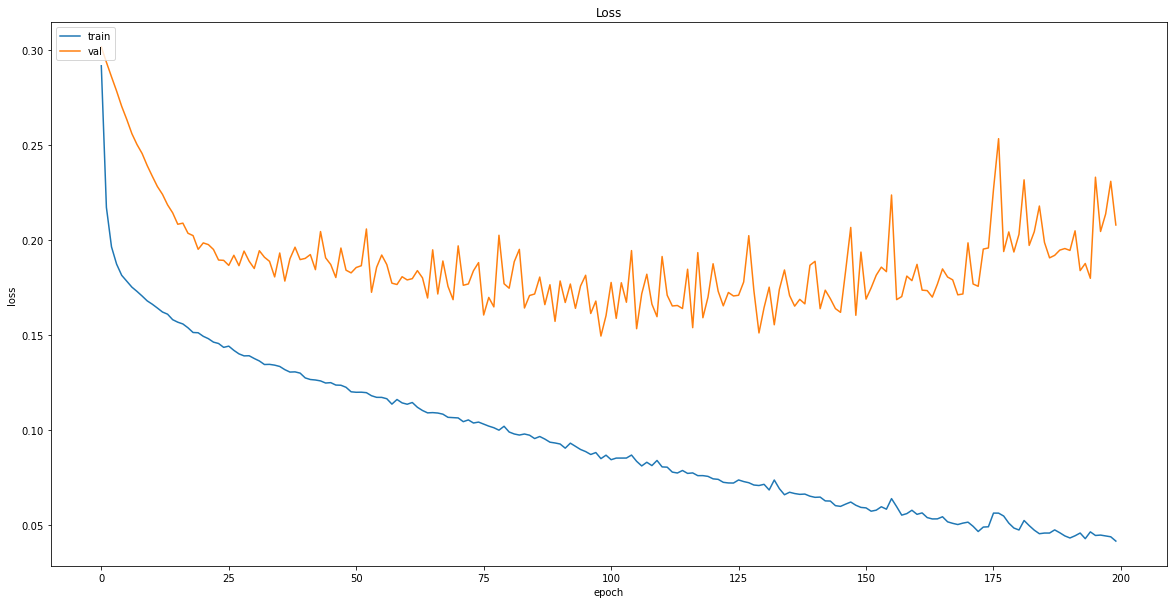

In [382]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [383]:
# Save model
model.save("models/{}".format('cnooc_time_series_lstm_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/cnooc_time_series_lstm_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [384]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-05,13.84,13.206983,-13.953473,9.687209e+09,2.0
2018-12-06,13.32,13.224370,-44.186053,9.629185e+09,2.0
2018-12-07,13.06,13.199082,-59.302288,9.569866e+09,2.0
2018-12-10,12.78,13.134608,-75.581395,9.417195e+09,2.0
2018-12-11,12.82,13.086207,-73.255816,9.502415e+09,2.0


In [385]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(211, 25, 4)

In [386]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [387]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1851 - accuracy: 0.7346 - mean_squared_error: 7.1329 - weighted_accuracy: 0.7346 - weighted_mean_squared_error: 7.1329
Test loss: 0.18507297337055206
Test accuracy: 0.7345971465110779


In [388]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 31, 2: 164, 1: 16})

In [389]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [390]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-390-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-390-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-390-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-14,13.46,13.005887,-9.090899,594167146.0,2.0,0,2
2019-02-15,13.28,13.075751,-2.222168,636062191.0,2.0,0,2
2019-02-18,13.68,13.107174,-22.222210,601994876.0,2.0,0,2
2019-02-19,13.76,13.195301,-15.384598,654106730.0,2.0,0,2
2019-02-20,13.92,13.282178,-9.230759,687559434.0,2.0,0,2


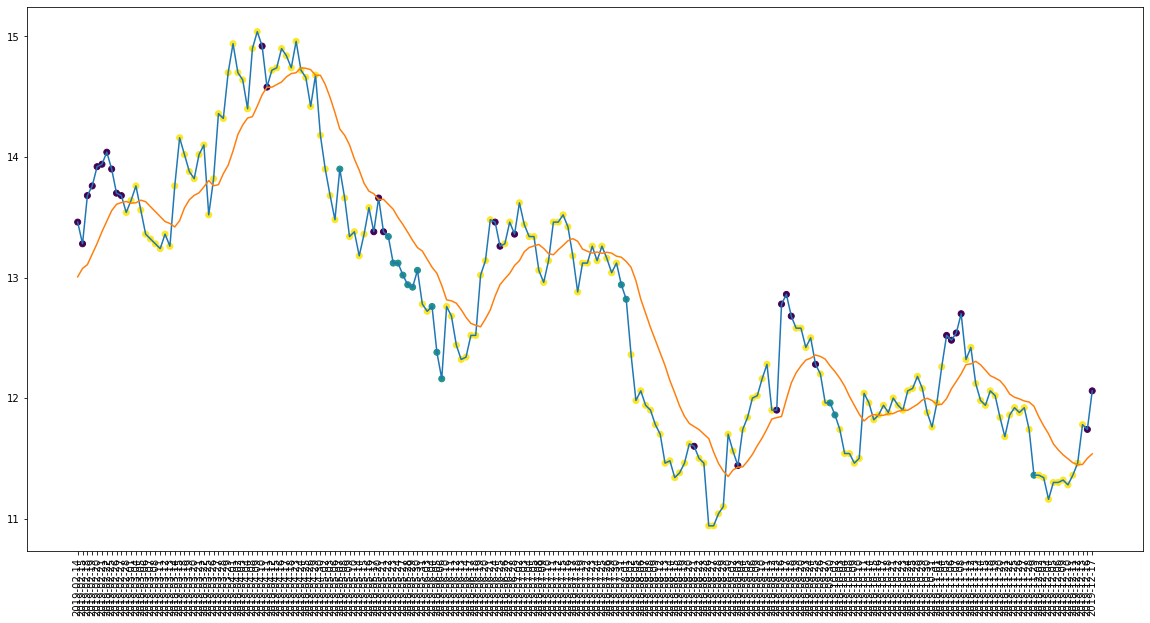

In [391]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

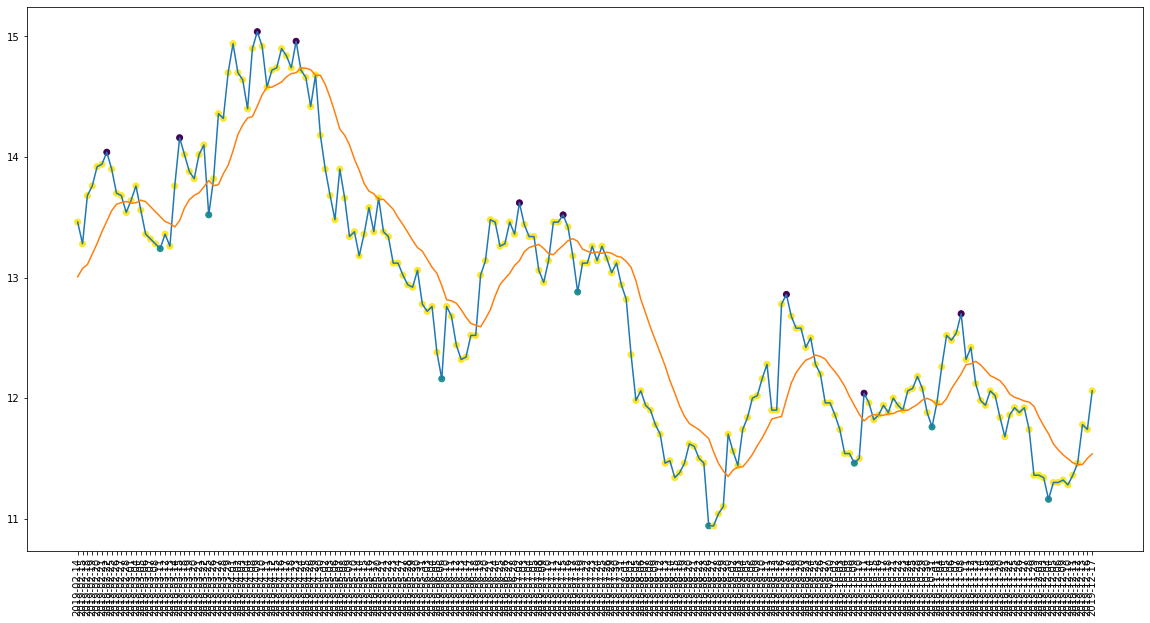

In [392]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [393]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 211
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 15
actual holds but predicted sell: 28
actual predicted holds: 151
Percentage buys correct: 12.5%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 77.83505154639175%
actual buys: 8
actual sells: 9
actual holds: 194


In [394]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 43.75%
Percentage sells correct: 61.29032258064516%
Percentage holds correct: 82.20858895705521%


In [395]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.899999618530273
Shares owned at the moment: 717
Cash capital at the moment: $6.29294926595685


Stop Loss Activated!

Share price: $13.34000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9544.769913370608


Share price: $13.34000015258789
Shares owned at the moment: 713
Cash capital at the moment: $7.19339927625515


Stop Loss Activated!

Share price: $12.9399995803833
Shares owned at the moment: 0
Cash capital at the moment: $9208.040995912312


Share price: $12.9399995803833
Shares owned at the moment: 709
Cash capital at the moment: $8.351529238698276


Stop Loss Activated!

Share price: $12.380000114440918
Shares owned at the moment: 0
Cash capital at the moment: $8761.633705154178


Share price: $12.380000114440918
Shares owned at the moment: 705
Cash capital at the moment: $9.731899251457435


Price increase from previously bought: 8.425576947099177%
Share price: $13.460000038146973
Shares owned at the moment: 0
Cash capital at the moment: $

In [396]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


### Recession

In [397]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-05,11.16,11.619972,-96.000004,-309527686.0,2.0
2019-12-06,11.30,11.570745,-81.249969,-265649189.0,2.0
2019-12-09,11.30,11.529092,-81.249969,-265649189.0,2.0
2019-12-10,11.32,11.496924,-79.166687,-219481840.0,2.0
2019-12-11,11.28,11.463551,-83.333350,-262942881.0,2.0


In [398]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(213, 25, 4)

In [399]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [400]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1812 - accuracy: 0.7606 - mean_squared_error: 7.3367 - weighted_accuracy: 0.7606 - weighted_mean_squared_error: 7.3367
Test loss: 0.18124476075172424
Test accuracy: 0.7605633735656738


In [401]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 174, 1: 24, 0: 15})

In [402]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [403]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-403-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-403-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-403-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-13,12.34,12.385912,-50.526328,113135355.0,2.0,2,2
2020-02-14,12.34,12.378849,-50.588221,60757697.0,2.0,2,2
2020-02-17,12.26,12.372872,-46.153851,60757697.0,2.0,2,2
2020-02-18,12.00,12.355507,-38.709648,5146960.0,2.0,2,2
2020-02-19,12.08,12.300814,-59.677412,-52626865.0,2.0,2,2


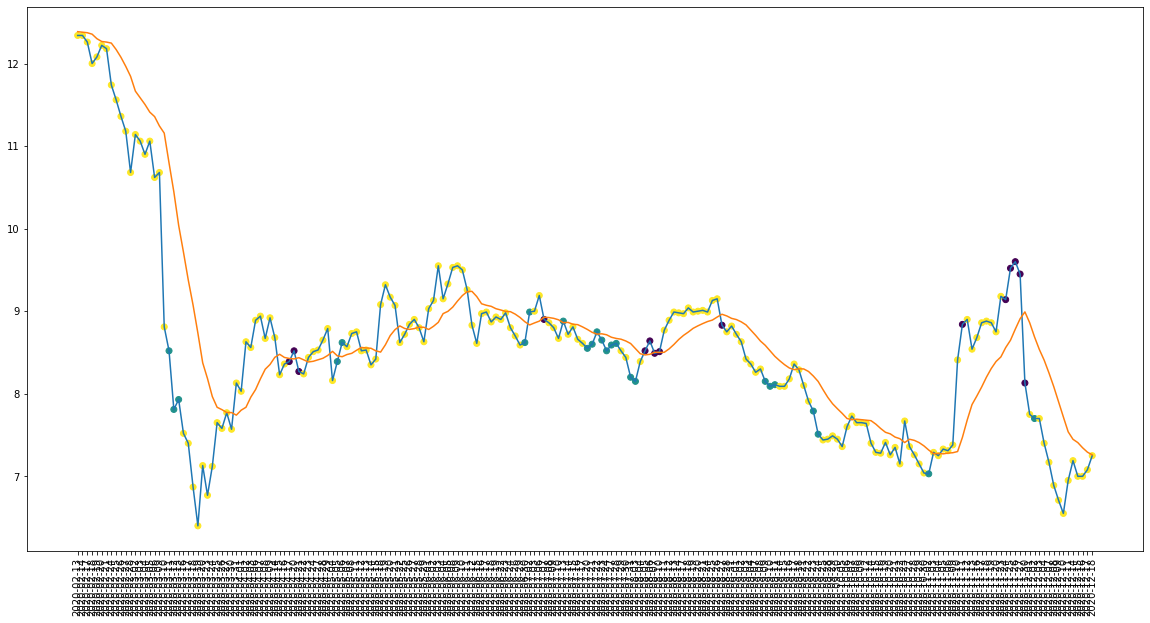

In [404]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

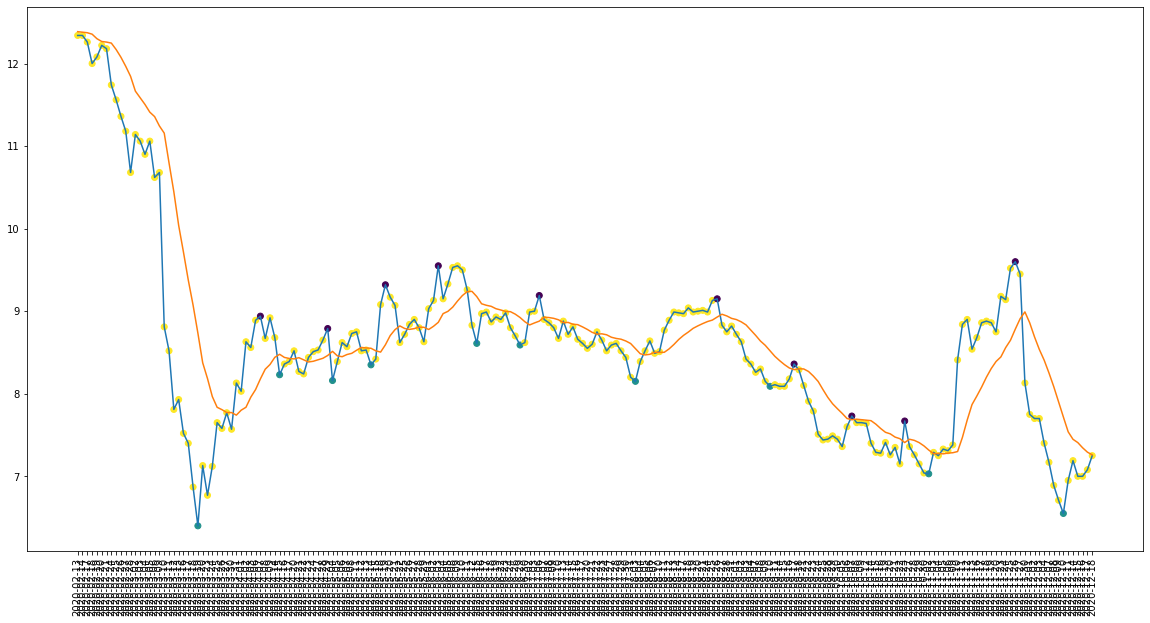

In [405]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [406]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 21
actual holds but predicted sell: 14
actual predicted holds: 158
Percentage buys correct: 30.0%
Percentage sells correct: 10.0%
Percentage holds correct: 81.86528497409327%
actual buys: 10
actual sells: 10
actual holds: 193


In [407]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 50.0%
Percentage sells correct: 53.333333333333336%
Percentage holds correct: 81.5028901734104%


In [408]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.520000457763674
Shares owned at the moment: 1170
Cash capital at the moment: $4.1863629436466


Stop Loss Activated!

Share price: $7.809999942779541
Shares owned at the moment: 0
Cash capital at the moment: $9116.757621179817


Share price: $7.809999942779541
Shares owned at the moment: 1164
Cash capital at the moment: $0.9178779675930855


Stop Loss Activated!

Share price: $7.519999980926514
Shares owned at the moment: 0
Cash capital at the moment: $8730.12633582711


Share price: $8.390000343322754
Shares owned at the moment: 1037
Cash capital at the moment: $5.769796322343609


Price increase from previously bought: 5.7877399052261636%
Share price: $8.899999618530273
Shares owned at the moment: 0
Cash capital at the moment: $9209.688826826094


Share price: $8.880000114440918
Shares owned at the moment: 1034
Cash capital at the moment: $2.518428168770697


Stop Loss Activated!

Share price: $8.609999656677246
Shares owned at the moment: 0
Cash capital at the moment

In [409]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


## JP Morgan

In [410]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


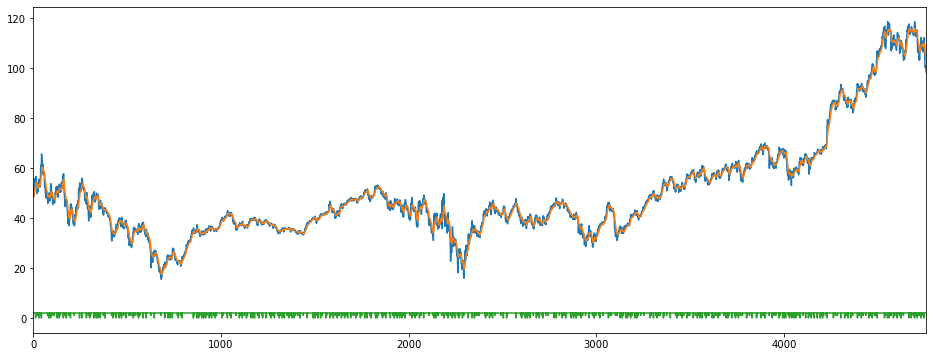

In [411]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [412]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [413]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(4735, 25, 4)

In [414]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [415]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [416]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [417]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [418]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 33ms/step - loss: 0.2899 - accuracy: 0.5649 - mse: 0.4407 - weighted_accuracy: 0.3277 - weighted_mse: 0.5298 - val_loss: 0.2990 - val_accuracy: 0.0454 - val_mse: 0.3548 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3548
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2122 - accuracy: 0.3986 - mse: 0.7584 - weighted_accuracy: 0.4279 - weighted_mse: 0.7544 - val_loss: 0.2897 - val_accuracy: 0.0454 - val_mse: 0.3865 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3865
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1904 - accuracy: 0.3242 - mse: 0.9975 - weighted_accuracy: 0.4844 - weighted_mse: 0.9639 - val_loss: 0.2810 - val_accuracy: 0.0454 - val_mse: 0.4292 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.4292
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1821 - accuracy: 0.2716 - mse: 1.1426 - weighted_accuracy: 0.5036 - weighte

Epoch 30/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1383 - accuracy: 0.3643 - mse: 1.7362 - weighted_accuracy: 0.6966 - weighted_mse: 1.6238 - val_loss: 0.2007 - val_accuracy: 0.2946 - val_mse: 1.7979 - val_weighted_accuracy: 0.2946 - val_weighted_mse: 1.7979
Epoch 31/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1375 - accuracy: 0.4158 - mse: 1.7538 - weighted_accuracy: 0.7138 - weighted_mse: 1.6596 - val_loss: 0.1913 - val_accuracy: 0.3675 - val_mse: 1.7270 - val_weighted_accuracy: 0.3675 - val_weighted_mse: 1.7270
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1378 - accuracy: 0.3878 - mse: 1.7591 - weighted_accuracy: 0.7150 - weighted_mse: 1.6546 - val_loss: 0.1972 - val_accuracy: 0.3442 - val_mse: 1.7688 - val_weighted_accuracy: 0.3442 - val_weighted_mse: 1.7688
Epoch 33/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1360 - accuracy: 0.3809 - mse: 1.7987 - weighted_accuracy: 0.7065 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1171 - accuracy: 0.5285 - mse: 2.3082 - weighted_accuracy: 0.7779 - weighted_mse: 2.2422 - val_loss: 0.1907 - val_accuracy: 0.4118 - val_mse: 2.4372 - val_weighted_accuracy: 0.4118 - val_weighted_mse: 2.4372
Epoch 60/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1142 - accuracy: 0.5446 - mse: 2.3255 - weighted_accuracy: 0.8048 - weighted_mse: 2.2792 - val_loss: 0.1816 - val_accuracy: 0.4678 - val_mse: 2.3285 - val_weighted_accuracy: 0.4678 - val_weighted_mse: 2.3285
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1137 - accuracy: 0.5412 - mse: 2.3408 - weighted_accuracy: 0.7903 - weighted_mse: 2.2981 - val_loss: 0.1868 - val_accuracy: 0.4308 - val_mse: 2.4083 - val_weighted_accuracy: 0.4308 - val_weighted_mse: 2.4083
Epoch 62/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1128 - accuracy: 0.5634 - mse: 2.3405 - weighted_accuracy: 0.8078 - weig

Epoch 88/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0946 - accuracy: 0.6840 - mse: 3.1258 - weighted_accuracy: 0.8539 - weighted_mse: 3.1092 - val_loss: 0.2239 - val_accuracy: 0.4287 - val_mse: 3.3499 - val_weighted_accuracy: 0.4287 - val_weighted_mse: 3.3499
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0914 - accuracy: 0.6579 - mse: 3.1554 - weighted_accuracy: 0.8614 - weighted_mse: 3.1506 - val_loss: 0.1725 - val_accuracy: 0.5808 - val_mse: 3.2143 - val_weighted_accuracy: 0.5808 - val_weighted_mse: 3.2143
Epoch 90/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0929 - accuracy: 0.6565 - mse: 3.2030 - weighted_accuracy: 0.8534 - weighted_mse: 3.1793 - val_loss: 0.1813 - val_accuracy: 0.5523 - val_mse: 3.4897 - val_weighted_accuracy: 0.5523 - val_weighted_mse: 3.4897
Epoch 91/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0893 - accuracy: 0.6940 - mse: 3.2093 - weighted_accuracy: 0.8749 - weig

Epoch 117/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0716 - accuracy: 0.7468 - mse: 4.3092 - weighted_accuracy: 0.8998 - weighted_mse: 4.2678 - val_loss: 0.1819 - val_accuracy: 0.6484 - val_mse: 4.3079 - val_weighted_accuracy: 0.6484 - val_weighted_mse: 4.3079
Epoch 118/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0715 - accuracy: 0.7629 - mse: 4.4089 - weighted_accuracy: 0.9076 - weighted_mse: 4.3335 - val_loss: 0.1836 - val_accuracy: 0.6294 - val_mse: 4.4216 - val_weighted_accuracy: 0.6294 - val_weighted_mse: 4.4216
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0704 - accuracy: 0.7753 - mse: 4.4632 - weighted_accuracy: 0.9025 - weighted_mse: 4.4643 - val_loss: 0.1866 - val_accuracy: 0.6220 - val_mse: 4.3482 - val_weighted_accuracy: 0.6220 - val_weighted_mse: 4.3482
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0693 - accuracy: 0.7785 - mse: 4.4596 - weighted_accuracy: 0.9171 - 

30/30 [==============================] - 0s 7ms/step - loss: 0.0599 - accuracy: 0.8086 - mse: 5.9849 - weighted_accuracy: 0.9205 - weighted_mse: 5.7758 - val_loss: 0.2088 - val_accuracy: 0.6642 - val_mse: 6.0948 - val_weighted_accuracy: 0.6642 - val_weighted_mse: 6.0948
Epoch 146/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0587 - accuracy: 0.8091 - mse: 5.8843 - weighted_accuracy: 0.9226 - weighted_mse: 5.6869 - val_loss: 0.1947 - val_accuracy: 0.6864 - val_mse: 6.2217 - val_weighted_accuracy: 0.6864 - val_weighted_mse: 6.2217
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0573 - accuracy: 0.8184 - mse: 5.9393 - weighted_accuracy: 0.9279 - weighted_mse: 5.6651 - val_loss: 0.1879 - val_accuracy: 0.6938 - val_mse: 5.8374 - val_weighted_accuracy: 0.6938 - val_weighted_mse: 5.8374
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0546 - accuracy: 0.8281 - mse: 6.0433 - weighted_accuracy: 0.9372 - weighted_mse: 

Epoch 174/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0441 - accuracy: 0.8712 - mse: 7.9977 - weighted_accuracy: 0.9510 - weighted_mse: 7.4540 - val_loss: 0.2553 - val_accuracy: 0.6452 - val_mse: 8.0720 - val_weighted_accuracy: 0.6452 - val_weighted_mse: 8.0720
Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0434 - accuracy: 0.8701 - mse: 7.9197 - weighted_accuracy: 0.9486 - weighted_mse: 7.3899 - val_loss: 0.2378 - val_accuracy: 0.7202 - val_mse: 8.9619 - val_weighted_accuracy: 0.7202 - val_weighted_mse: 8.9619
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0443 - accuracy: 0.8683 - mse: 8.1553 - weighted_accuracy: 0.9480 - weighted_mse: 7.5710 - val_loss: 0.2217 - val_accuracy: 0.7212 - val_mse: 8.2022 - val_weighted_accuracy: 0.7212 - val_weighted_mse: 8.2022
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0428 - accuracy: 0.8733 - mse: 8.3399 - weighted_accuracy: 0.9518 - 

In [419]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2657029330730438
Test accuracy: 0.748680055141449


In [420]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.2891169  -3.490533    1.648265  ]
 [-5.8057504  -2.4801006   1.8843669 ]
 [-0.377042   -7.336236   -0.21034658]
 ...
 [-3.511575   -2.3839924   1.9410158 ]
 [-4.825186   -5.14699     4.078914  ]
 [-3.7632995  -6.2476892   3.8008146 ]]


Counter({2: 783, 1: 76, 0: 88})

In [421]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 863, 0: 41, 1: 43})

In [422]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 947
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 42
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 37
actual holds but predicted buy: 75
actual holds but predicted sell: 84
actual predicted holds: 704
Percentage buys correct: 2.3255813953488373%
Percentage sells correct: 9.75609756097561%
Percentage holds correct: 81.57589803012746%
actual buys: 43
actual sells: 41
actual holds: 863


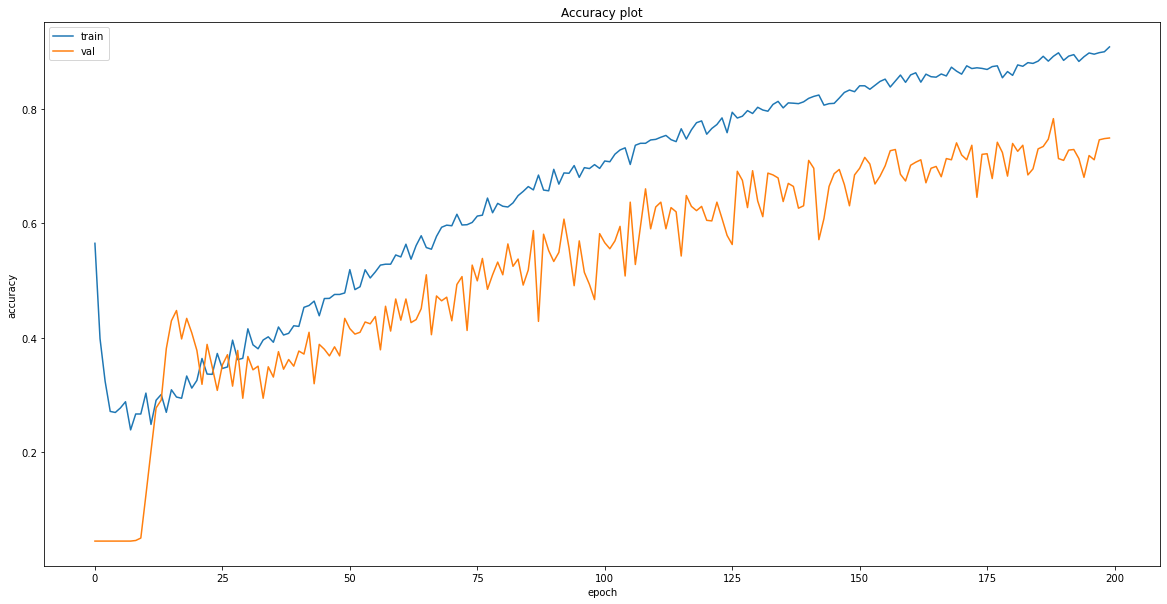

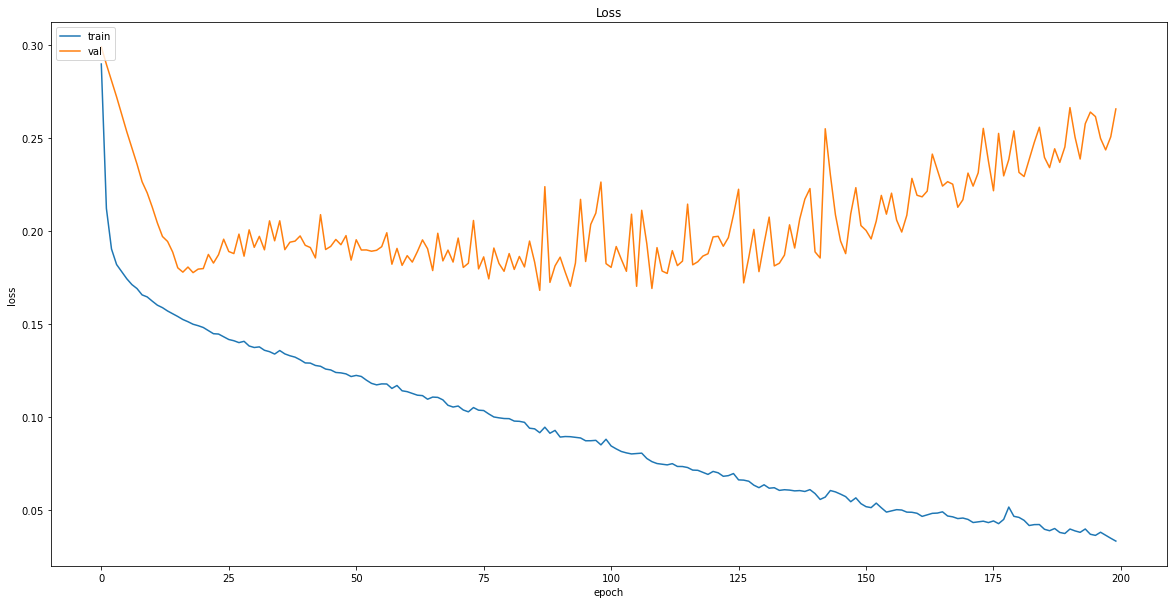

In [423]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [424]:
# Save model
model.save("models/{}".format('jpm_time_series_lstm_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/jpm_time_series_lstm_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [425]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-06,107.230003,109.628444,-81.910265,-1.924741e+09,2.0
2018-12-07,105.190002,108.945607,-76.923030,-1.951955e+09,2.0
2018-12-10,103.290001,108.075514,-95.904060,-1.971203e+09,2.0
2018-12-11,101.360001,107.042358,-84.717107,-1.994840e+09,2.0
2018-12-12,100.370003,106.015842,-91.991154,-2.011700e+09,2.0


In [426]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(218, 25, 4)

In [427]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [428]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2406 - accuracy: 0.6927 - mean_squared_error: 13.0930 - weighted_accuracy: 0.6927 - weighted_mean_squared_error: 13.0930
Test loss: 0.24063575267791748
Test accuracy: 0.6926605701446533


In [429]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 154, 1: 31, 0: 33})

In [430]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [431]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-431-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-431-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-431-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,100.879997,102.975915,-74.903417,73097300.0,1.0,2,1
2019-02-12,102.599998,102.653466,-84.169891,62118800.0,2.0,2,2
2019-02-13,103.089996,102.645240,-50.965236,74971100.0,2.0,2,2
2019-02-14,102.419998,102.713664,-41.505819,85725200.0,2.0,2,2
2019-02-15,105.550003,102.668485,-54.440145,74206700.0,2.0,2,2


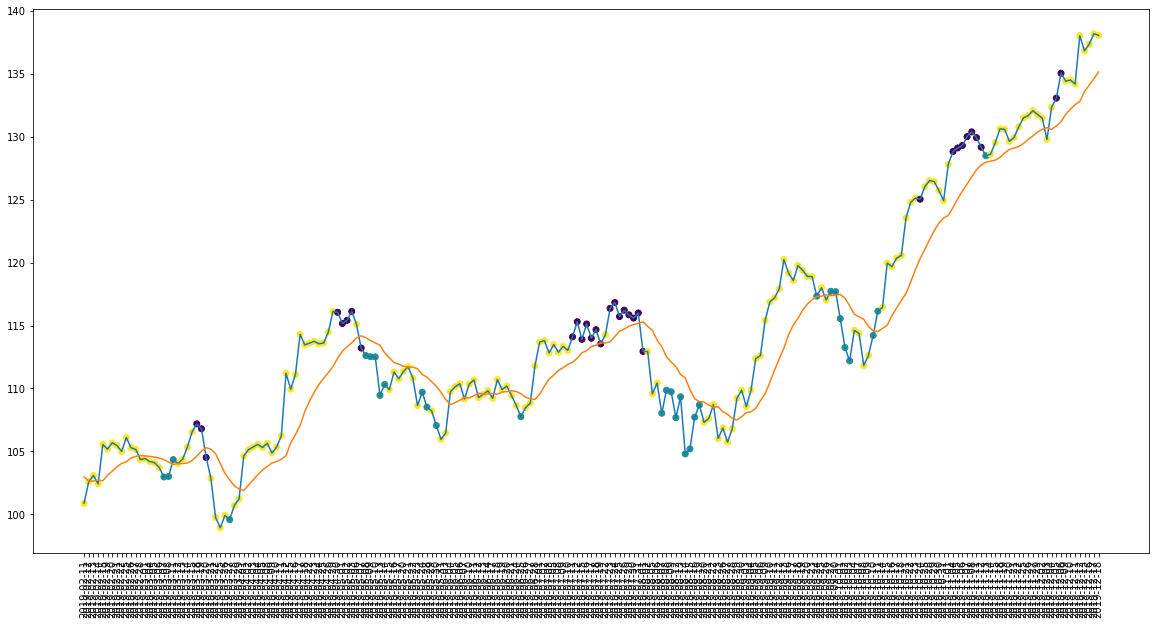

In [432]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

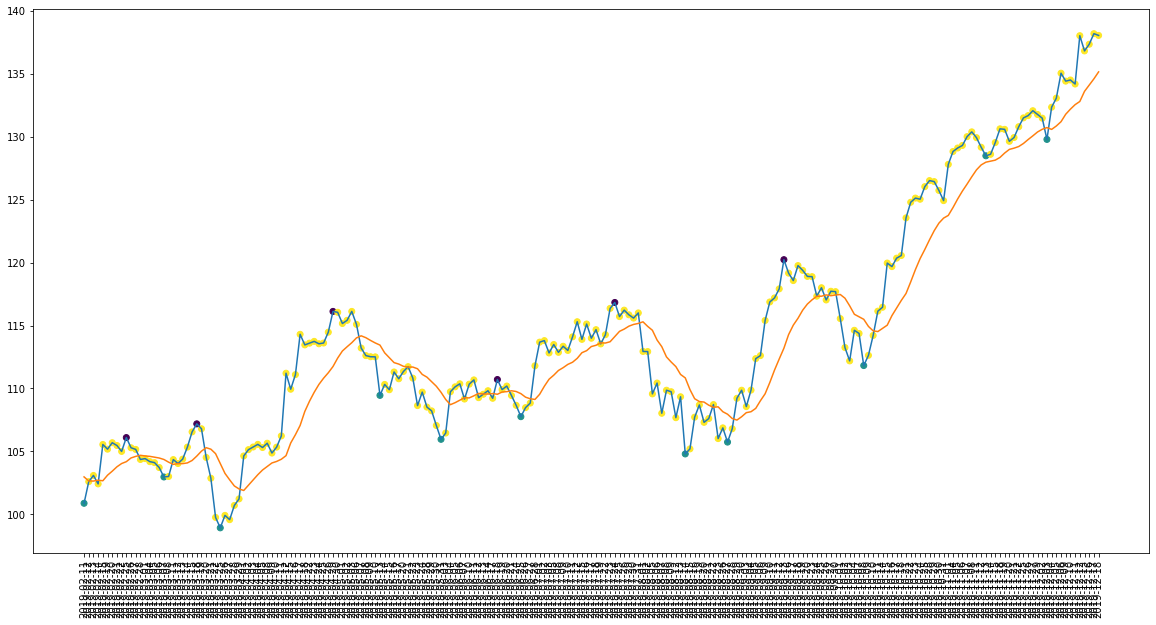

In [433]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [434]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 4
actual holds but predicted buy: 26
actual holds but predicted sell: 31
actual predicted holds: 144
Percentage buys correct: 45.45454545454545%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 71.64179104477611%
actual buys: 11
actual sells: 6
actual holds: 201


In [435]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 51.61290322580645%
Percentage sells correct: 51.515151515151516%
Percentage holds correct: 86.9281045751634%


In [436]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $102.97000122070312
Shares owned at the moment: 96
Cash capital at the moment: $87.6958024902342


Stop Loss Activated!

Share price: $99.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9638.319367004397


Share price: $99.58000183105469
Shares owned at the moment: 96
Cash capital at the moment: $52.350070739747025


Price increase from previously bought: 16.219862057246193%
Share price: $116.0500030517578
Shares owned at the moment: 0
Cash capital at the moment: $11162.513162902831


Share price: $112.61000061035156
Shares owned at the moment: 98
Cash capital at the moment: $96.38470792388762


Stop Loss Activated!

Share price: $109.4499969482422
Shares owned at the moment: 0
Cash capital at the moment: $10792.987634674073


Share price: $109.4499969482422
Shares owned at the moment: 98
Cash capital at the moment: $37.39115956878595


Stop Loss Activated!

Share price: $105.95999908447266
Shares owned at the moment: 0
Cash capital at the moment:

In [437]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


### recession

In [466]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-06,133.059998,131.187618,-5.091646,270369900.0,2.0
2019-12-09,135.039993,131.780291,-10.292145,280540500.0,2.0
2019-12-10,134.410004,132.184862,-19.054168,272042300.0,2.0
2019-12-11,134.500000,132.541037,-17.802480,279575200.0,2.0
2019-12-12,134.179993,132.793184,-22.253207,270563300.0,2.0


In [467]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(219, 25, 4)

In [468]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [469]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1346 - accuracy: 0.8037 - mean_squared_error: 10.3221 - weighted_accuracy: 0.8037 - weighted_mean_squared_error: 10.3221
Test loss: 0.134608194231987
Test accuracy: 0.8036529421806335


In [470]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 180, 1: 18, 0: 21})

In [471]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [472]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-472-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-472-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-472-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,138.000000,136.179383,-6.410124,26757600.0,0.0,2,0
2020-02-12,138.000000,136.459478,-9.001177,33336200.0,2.0,2,2
2020-02-13,137.880005,136.696481,-13.465502,33336200.0,2.0,2,2
2020-02-14,137.460007,136.878562,-14.718062,25888700.0,2.0,2,2
2020-02-18,135.639999,136.968015,-23.401387,19261100.0,2.0,2,2


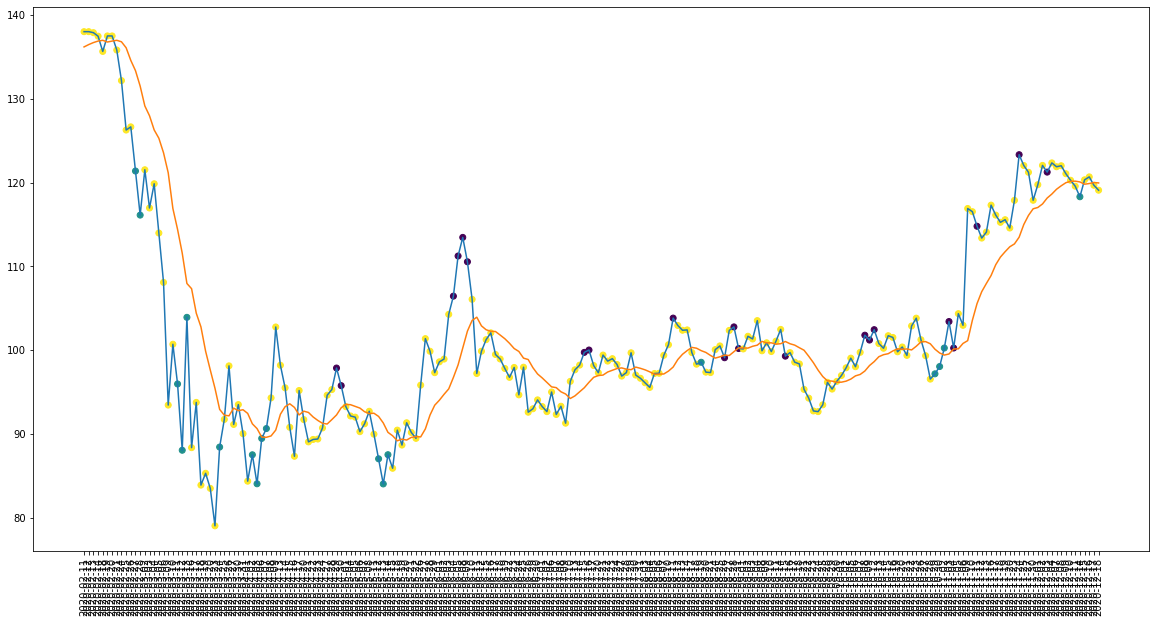

In [473]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

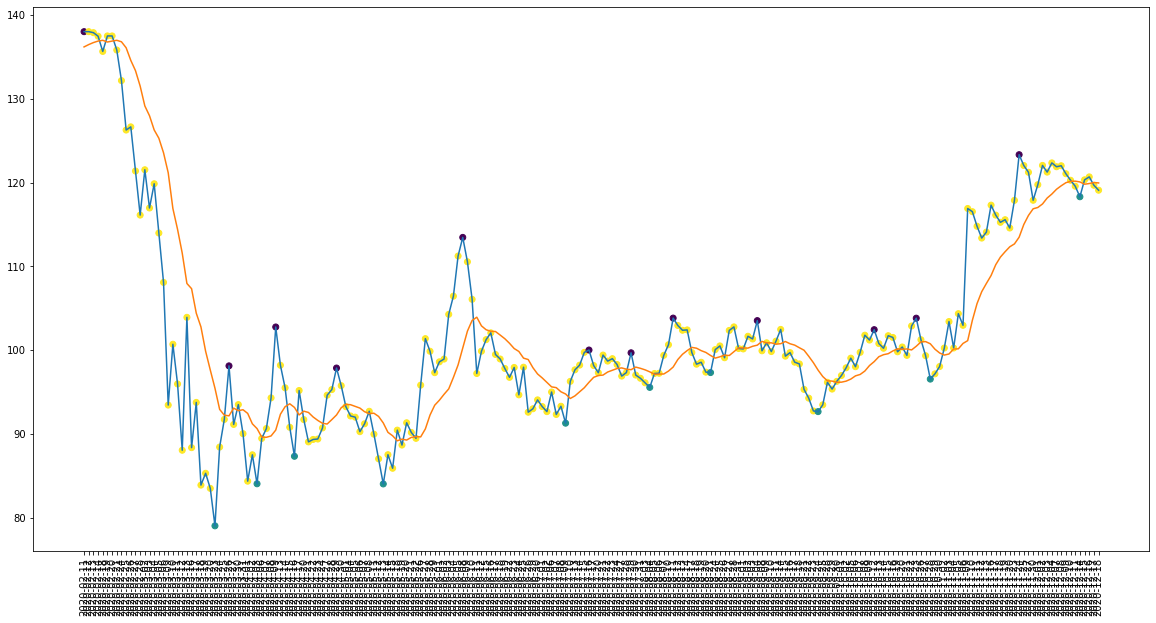

In [474]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [475]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 15
actual holds but predicted sell: 15
actual predicted holds: 167
Percentage buys correct: 30.0%
Percentage sells correct: 50.0%
Percentage holds correct: 84.77157360406092%
actual buys: 10
actual sells: 12
actual holds: 197


In [476]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 72.22222222222223%
Percentage sells correct: 71.42857142857143%
Percentage holds correct: 84.91620111731844%


In [477]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $121.37000274658205
Shares owned at the moment: 82
Cash capital at the moment: $20.29083916091622


Stop Loss Activated!

Share price: $116.11000061035156
Shares owned at the moment: 0
Cash capital at the moment: $9515.12808407211


Share price: $116.11000061035156
Shares owned at the moment: 81
Cash capital at the moment: $84.35453199767835


Stop Loss Activated!

Share price: $108.08000183105469
Shares owned at the moment: 0
Cash capital at the moment: $8814.75985990524


Share price: $95.95999908447266
Shares owned at the moment: 91
Cash capital at the moment: $58.38595344733949


Stop Loss Activated!

Share price: $88.05000305175781
Shares owned at the moment: 0
Cash capital at the moment: $8048.901717893597


Share price: $88.05000305175781
Shares owned at the moment: 91
Cash capital at the moment: $14.316926919933394


Stop Loss Activated!

Share price: $83.88999938964844
Shares owned at the moment: 0
Cash capital at the moment: $7627.3133990306815


Share price: $88

In [478]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [451]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


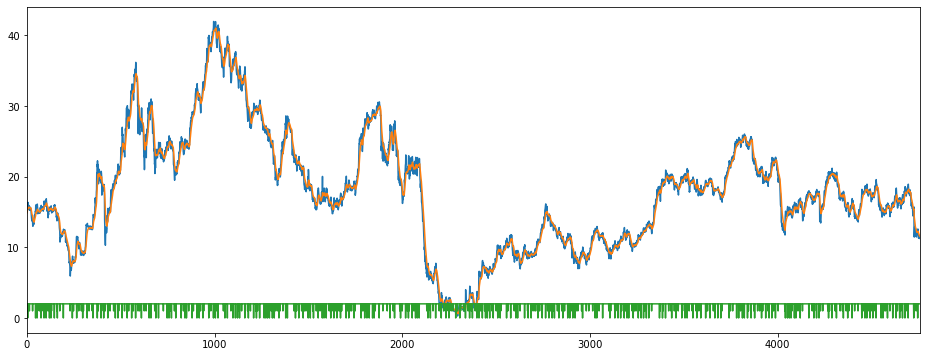

In [452]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [453]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.0625,14.895987,-18.478261,298700.0,2.0
2000-01-24,15.8750,15.046605,-22.222222,293100.0,2.0
2000-01-25,15.7500,15.154819,-26.190476,286300.0,2.0
2000-01-26,15.7500,15.246386,-29.729730,286300.0,2.0
2000-01-27,16.0000,15.362326,-25.000000,311700.0,0.0


In [454]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(4735, 25, 4)

In [455]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [456]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [457]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [458]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [459]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2872 - accuracy: 0.5686 - mse: 0.4423 - weighted_accuracy: 0.3292 - weighted_mse: 0.5263 - val_loss: 0.2987 - val_accuracy: 0.0422 - val_mse: 0.3551 - val_weighted_accuracy: 0.0422 - val_weighted_mse: 0.3551
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2125 - accuracy: 0.4047 - mse: 0.7650 - weighted_accuracy: 0.4113 - weighted_mse: 0.7703 - val_loss: 0.2888 - val_accuracy: 0.0465 - val_mse: 0.3857 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 0.3857
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1940 - accuracy: 0.3205 - mse: 1.0114 - weighted_accuracy: 0.4751 - weighted_mse: 0.9872 - val_loss: 0.2781 - val_accuracy: 0.0465 - val_mse: 0.4238 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 0.4238
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1860 - accuracy: 0.3023 - mse: 1.1296 - weighted_accuracy: 0.5122 - weighte

30/30 [==============================] - 0s 7ms/step - loss: 0.1453 - accuracy: 0.3910 - mse: 1.5166 - weighted_accuracy: 0.6835 - weighted_mse: 1.4280 - val_loss: 0.1892 - val_accuracy: 0.3664 - val_mse: 1.4855 - val_weighted_accuracy: 0.3664 - val_weighted_mse: 1.4855
Epoch 30/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1446 - accuracy: 0.3838 - mse: 1.5214 - weighted_accuracy: 0.6754 - weighted_mse: 1.4344 - val_loss: 0.1826 - val_accuracy: 0.4171 - val_mse: 1.4887 - val_weighted_accuracy: 0.4171 - val_weighted_mse: 1.4887
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1424 - accuracy: 0.3957 - mse: 1.5458 - weighted_accuracy: 0.6962 - weighted_mse: 1.4517 - val_loss: 0.1922 - val_accuracy: 0.3654 - val_mse: 1.5385 - val_weighted_accuracy: 0.3654 - val_weighted_mse: 1.5385
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1429 - accuracy: 0.3759 - mse: 1.5746 - weighted_accuracy: 0.6944 - weighted_mse: 1.4

30/30 [==============================] - 0s 8ms/step - loss: 0.1206 - accuracy: 0.5121 - mse: 1.9132 - weighted_accuracy: 0.7936 - weighted_mse: 1.8174 - val_loss: 0.1772 - val_accuracy: 0.4942 - val_mse: 1.9709 - val_weighted_accuracy: 0.4942 - val_weighted_mse: 1.9709
Epoch 58/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1201 - accuracy: 0.5230 - mse: 1.9624 - weighted_accuracy: 0.7867 - weighted_mse: 1.8826 - val_loss: 0.1809 - val_accuracy: 0.4900 - val_mse: 1.9645 - val_weighted_accuracy: 0.4900 - val_weighted_mse: 1.9645
Epoch 59/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1205 - accuracy: 0.5211 - mse: 1.9420 - weighted_accuracy: 0.7787 - weighted_mse: 1.8475 - val_loss: 0.1920 - val_accuracy: 0.4361 - val_mse: 1.9939 - val_weighted_accuracy: 0.4361 - val_weighted_mse: 1.9939
Epoch 60/200
30/30 [==============================] - 0s 8ms/step - loss: 0.1195 - accuracy: 0.5177 - mse: 2.0012 - weighted_accuracy: 0.7957 - weighted_mse: 1.9

Epoch 86/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0960 - accuracy: 0.6402 - mse: 2.5976 - weighted_accuracy: 0.8498 - weighted_mse: 2.5108 - val_loss: 0.1660 - val_accuracy: 0.5956 - val_mse: 2.6930 - val_weighted_accuracy: 0.5956 - val_weighted_mse: 2.6930
Epoch 87/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0969 - accuracy: 0.6436 - mse: 2.6818 - weighted_accuracy: 0.8528 - weighted_mse: 2.5948 - val_loss: 0.1978 - val_accuracy: 0.5238 - val_mse: 2.8331 - val_weighted_accuracy: 0.5238 - val_weighted_mse: 2.8331
Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0952 - accuracy: 0.6513 - mse: 2.6457 - weighted_accuracy: 0.8611 - weighted_mse: 2.5751 - val_loss: 0.1964 - val_accuracy: 0.5333 - val_mse: 2.8790 - val_weighted_accuracy: 0.5333 - val_weighted_mse: 2.8790
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0937 - accuracy: 0.6534 - mse: 2.7158 - weighted_accuracy: 0.8564 - weig

Epoch 115/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0767 - accuracy: 0.7276 - mse: 3.6002 - weighted_accuracy: 0.8927 - weighted_mse: 3.4442 - val_loss: 0.1679 - val_accuracy: 0.6705 - val_mse: 3.9089 - val_weighted_accuracy: 0.6705 - val_weighted_mse: 3.9089
Epoch 116/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0751 - accuracy: 0.7621 - mse: 3.6496 - weighted_accuracy: 0.9109 - weighted_mse: 3.5424 - val_loss: 0.1943 - val_accuracy: 0.6072 - val_mse: 3.6740 - val_weighted_accuracy: 0.6072 - val_weighted_mse: 3.6740
Epoch 117/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0726 - accuracy: 0.7579 - mse: 3.7027 - weighted_accuracy: 0.9075 - weighted_mse: 3.5583 - val_loss: 0.1774 - val_accuracy: 0.6473 - val_mse: 4.0516 - val_weighted_accuracy: 0.6473 - val_weighted_mse: 4.0516
Epoch 118/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0741 - accuracy: 0.7521 - mse: 3.7841 - weighted_accuracy: 0.8999 - 

Epoch 144/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0580 - accuracy: 0.8126 - mse: 5.0441 - weighted_accuracy: 0.9203 - weighted_mse: 4.7131 - val_loss: 0.1964 - val_accuracy: 0.6895 - val_mse: 5.5450 - val_weighted_accuracy: 0.6895 - val_weighted_mse: 5.5450
Epoch 145/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0580 - accuracy: 0.8300 - mse: 5.1525 - weighted_accuracy: 0.9340 - weighted_mse: 4.7684 - val_loss: 0.1805 - val_accuracy: 0.6832 - val_mse: 5.4298 - val_weighted_accuracy: 0.6832 - val_weighted_mse: 5.4298
Epoch 146/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0587 - accuracy: 0.8112 - mse: 5.1630 - weighted_accuracy: 0.9271 - weighted_mse: 4.8189 - val_loss: 0.2025 - val_accuracy: 0.6779 - val_mse: 5.7504 - val_weighted_accuracy: 0.6779 - val_weighted_mse: 5.7504
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0554 - accuracy: 0.8345 - mse: 5.2477 - weighted_accuracy: 0.9374 - 

Epoch 173/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0478 - accuracy: 0.8548 - mse: 6.6558 - weighted_accuracy: 0.9412 - weighted_mse: 5.9548 - val_loss: 0.2204 - val_accuracy: 0.7012 - val_mse: 6.9581 - val_weighted_accuracy: 0.7012 - val_weighted_mse: 6.9581
Epoch 174/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0471 - accuracy: 0.8640 - mse: 6.6106 - weighted_accuracy: 0.9428 - weighted_mse: 6.0033 - val_loss: 0.2249 - val_accuracy: 0.6927 - val_mse: 7.0226 - val_weighted_accuracy: 0.6927 - val_weighted_mse: 7.0226
Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0473 - accuracy: 0.8611 - mse: 6.7459 - weighted_accuracy: 0.9490 - weighted_mse: 6.1313 - val_loss: 0.2466 - val_accuracy: 0.6610 - val_mse: 7.3983 - val_weighted_accuracy: 0.6610 - val_weighted_mse: 7.3983
Epoch 176/200
30/30 [==============================] - 0s 8ms/step - loss: 0.0474 - accuracy: 0.8567 - mse: 6.7362 - weighted_accuracy: 0.9401 - 

In [460]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.22476190328598022
Test accuracy: 0.7518479228019714


In [461]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.9095035  -4.561761    2.2057323 ]
 [-2.94816    -0.9730391   0.07552114]
 [-3.8671417  -2.7920167   1.857093  ]
 ...
 [-2.6481063  -4.0839753   1.9543113 ]
 [-0.4277807  -6.306809   -0.54400724]
 [-4.4305177  -2.875564    2.4105306 ]]


Counter({2: 782, 0: 83, 1: 82})

In [462]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 860, 0: 43, 1: 44})

In [463]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 947
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 42
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 36
actual holds but predicted buy: 81
actual holds but predicted sell: 75
actual predicted holds: 704
Percentage buys correct: 2.272727272727273%
Percentage sells correct: 16.27906976744186%
Percentage holds correct: 81.86046511627907%
actual buys: 44
actual sells: 43
actual holds: 860


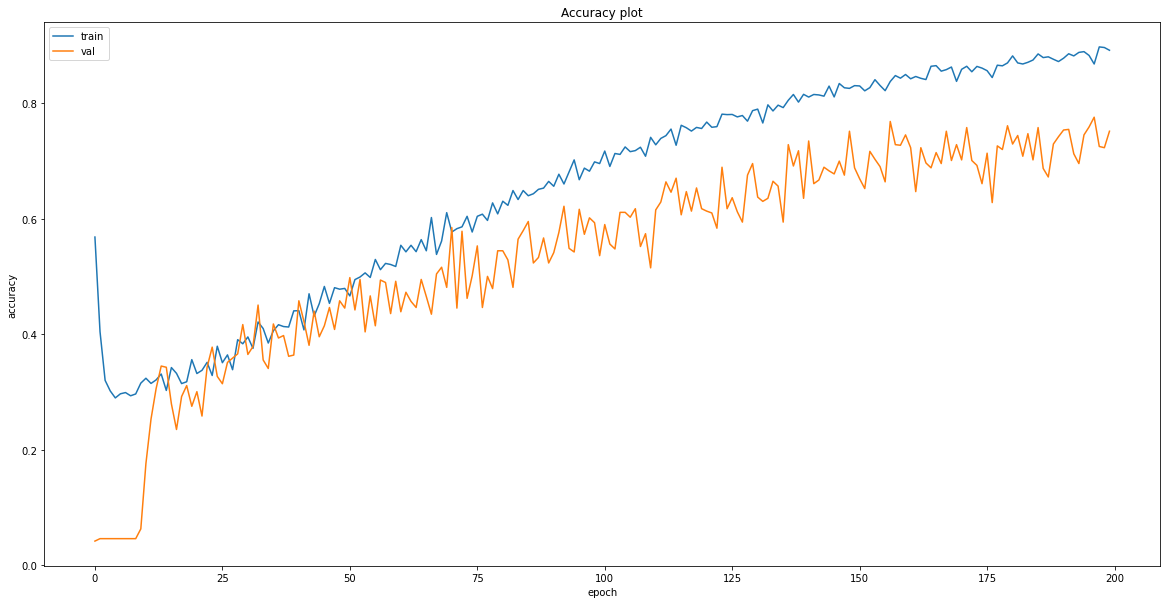

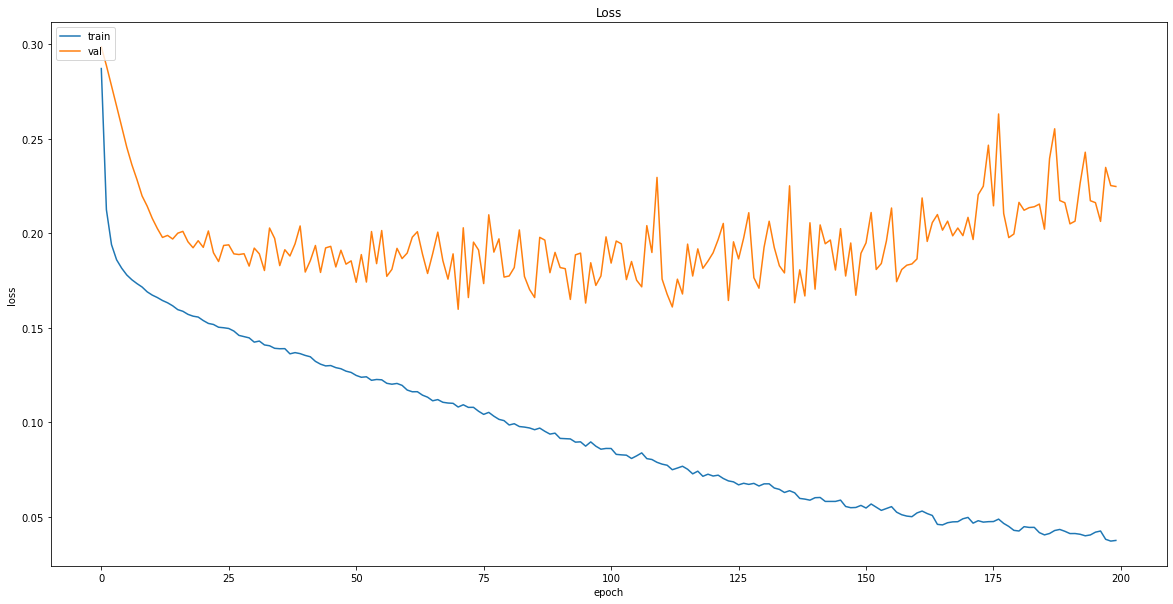

In [464]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [465]:
# Save model
model.save("models/{}".format('axl_time_series_lstm_buy_hold_sell_25.model'))

INFO:tensorflow:Assets written to: models/axl_time_series_lstm_buy_hold_sell_25.model\assets


### Test Performance

### non-recession

In [479]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2018-12-06,12.27,12.266266,-43.949026,234486200.0,2.0
2018-12-07,11.98,12.222225,-62.420426,231459100.0,2.0
2018-12-10,11.33,12.084959,-93.678180,229051600.0,2.0
2018-12-11,11.38,11.976504,-73.831760,231349000.0,2.0
2018-12-12,11.32,11.875503,-76.635518,229316700.0,2.0


In [480]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(218, 25, 4)

In [481]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [482]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1984 - accuracy: 0.7890 - mean_squared_error: 10.0057 - weighted_accuracy: 0.7890 - weighted_mean_squared_error: 10.0057
Test loss: 0.19839166104793549
Test accuracy: 0.78899085521698


In [483]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 183, 0: 22, 1: 13})

In [484]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [485]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-485-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-485-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-485-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,14.01,14.312907,-83.060094,17347800.0,2.0,2,2
2019-02-12,14.34,14.266306,-68.852439,19189100.0,2.0,2,2
2019-02-13,14.45,14.277643,-50.819664,21493700.0,2.0,2,2
2019-02-14,14.70,14.304160,-44.808757,23008200.0,2.0,2,2
2019-02-15,16.83,14.365058,-31.147561,25735200.0,2.0,2,2


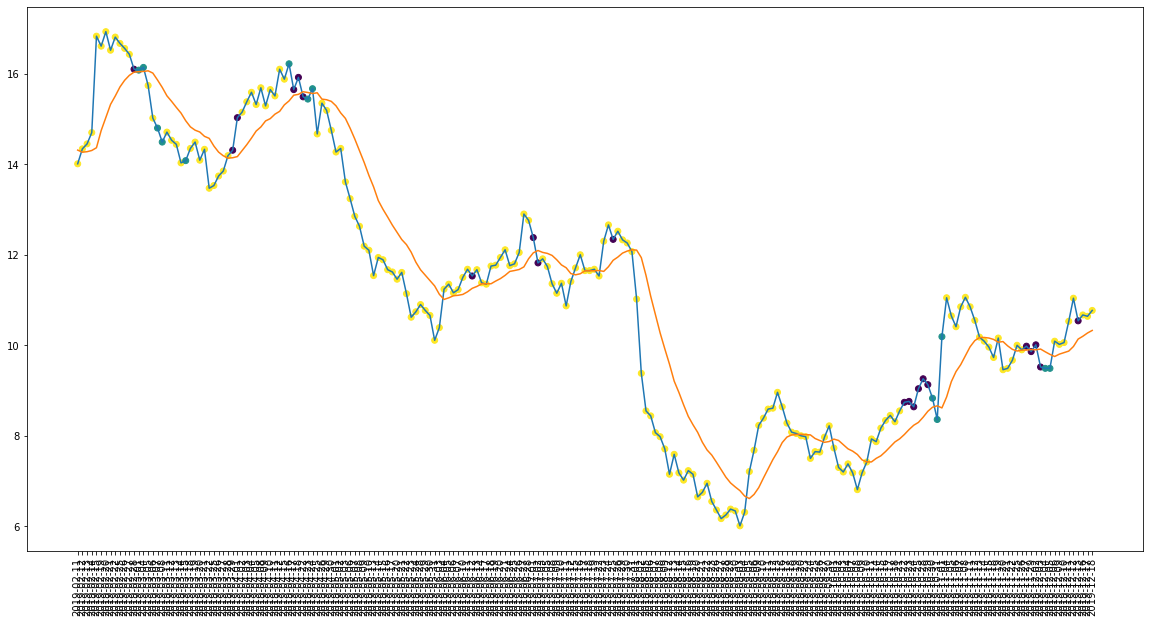

In [486]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

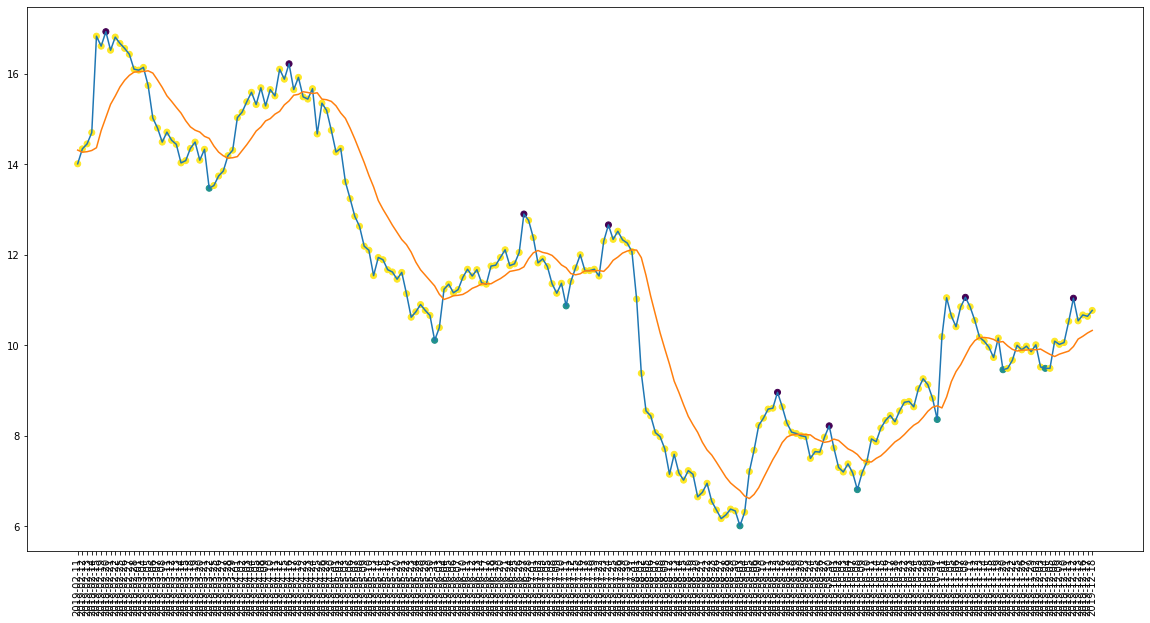

In [487]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [488]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 7
actual holds but predicted buy: 10
actual holds but predicted sell: 22
actual predicted holds: 170
Percentage buys correct: 25.0%
Percentage sells correct: 0.0%
Percentage holds correct: 84.15841584158416%
actual buys: 8
actual sells: 8
actual holds: 202


In [489]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 61.53846153846154%
Percentage sells correct: 52.38095238095238%
Percentage holds correct: 85.24590163934427%


In [490]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $16.079999923706055
Shares owned at the moment: 620
Cash capital at the moment: $2.983647432327416


Stop Loss Activated!

Share price: $15.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9289.774830465316


Share price: $14.800000190734865
Shares owned at the moment: 625
Cash capital at the moment: $14.337210928199056


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $8758.972981994151


Share price: $14.079999923706055
Shares owned at the moment: 620
Cash capital at the moment: $5.366629426478539


Stop Loss Activated!

Share price: $13.470000267028807
Shares owned at the moment: 0
Cash capital at the moment: $8333.800444529053


Share price: $16.219999313354492
Shares owned at the moment: 512
Cash capital at the moment: $6.323037058349655


Stop Loss Activated!

Share price: $15.649999618530273
Shares owned at the moment: 0
Cash capital at the moment: $7997.087642282959


Share p

In [491]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


### recession

In [492]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df2.set_index('Date', inplace=True)
df2 = df2.iloc[-10:]
df2 = pd.concat([df2,df])
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-12-06,9.49,9.751830,-78.151251,-15220600.0,2.0
2019-12-09,10.09,9.803856,-27.731074,-13947000.0,2.0
2019-12-10,10.02,9.837109,-33.613398,-14784200.0,2.0
2019-12-11,10.06,9.871400,-30.252058,-12899200.0,2.0
2019-12-12,10.53,9.972723,-7.801457,-10425400.0,0.0


In [493]:
labels = []
data_25 = []
sequential = []
count = 0

for i in df2.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 25, 4)
y = labels
y = np.array(y)
X.shape

(219, 25, 4)

In [494]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [495]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_25.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1867 - accuracy: 0.7671 - mean_squared_error: 8.7448 - weighted_accuracy: 0.7671 - weighted_mean_squared_error: 8.7448
Test loss: 0.18665553629398346
Test accuracy: 0.767123281955719


In [496]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 180, 1: 10, 0: 29})

In [497]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [498]:
df = df2.iloc[24:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

<ipython-input-498-09f5a663af61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-498-09f5a663af61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-498-09f5a663af61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,9.84,9.643918,-57.638900,-3274300.0,2.0,2,2
2020-02-12,10.34,9.674085,-36.805548,-1876100.0,0.0,2,0
2020-02-13,10.22,9.776533,-16.568036,-291400.0,2.0,2,2
2020-02-14,8.77,9.844759,-23.668622,-1567700.0,2.0,2,2
2020-02-18,8.27,9.679411,-90.686248,-6644000.0,2.0,2,2


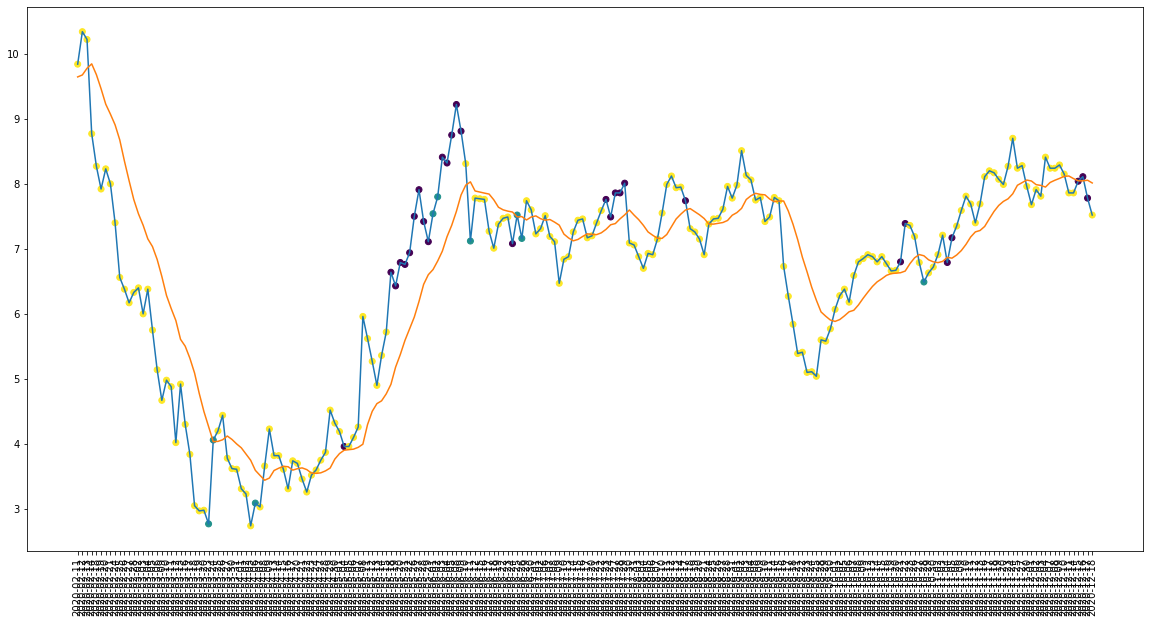

In [499]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

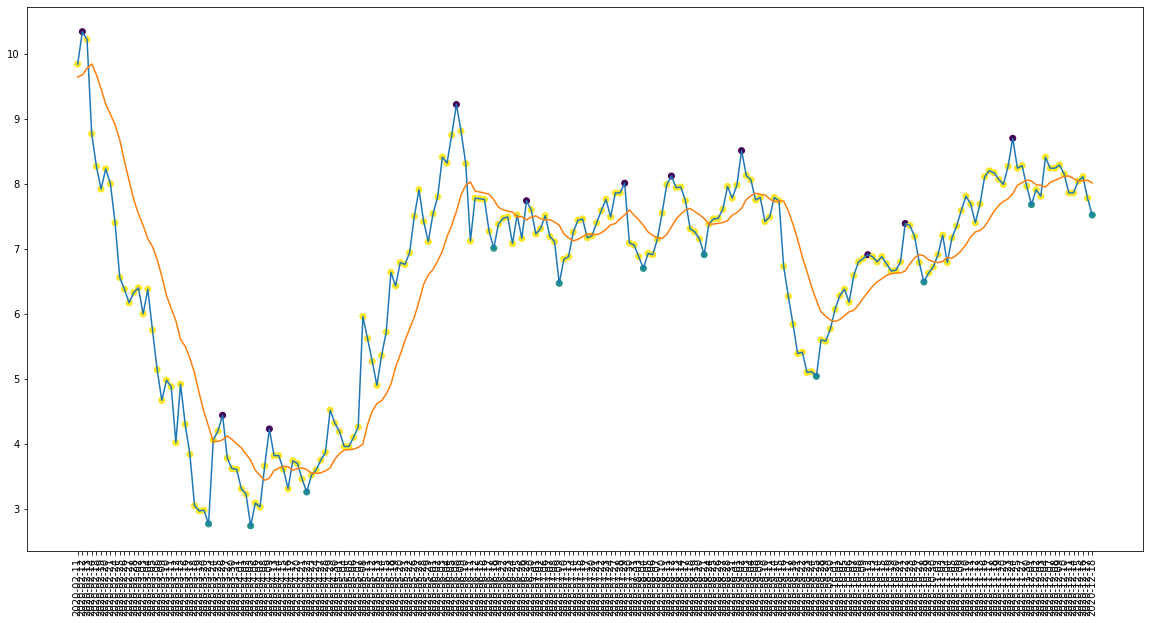

In [500]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [501]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 8
actual holds but predicted sell: 26
actual predicted holds: 163
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 27.272727272727273%
Percentage holds correct: 82.74111675126903%
actual buys: 11
actual sells: 11
actual holds: 197


In [502]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 77.77777777777777%
Percentage sells correct: 51.724137931034484%
Percentage holds correct: 85.55555555555556%


In [503]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $2.7699999809265137
Shares owned at the moment: 3600
Cash capital at the moment: $0.5770688533775683


Price increase from previously bought: 42.56822854170827%
Share price: $3.9600000381469727
Shares owned at the moment: 0
Cash capital at the moment: $14217.373205804824


Share price: $7.539999961853027
Shares owned at the moment: 1880
Cash capital at the moment: $3.191477718351962


Price increase from previously bought: 11.232570510150897%
Share price: $8.409999847412111
Shares owned at the moment: 0
Cash capital at the moment: $15770.511491642


Share price: $7.119999885559082
Shares owned at the moment: 2208
Cash capital at the moment: $6.319105022432268


Stop Loss Activated!

Share price: $6.46999979019165
Shares owned at the moment: 0
Cash capital at the moment: $14252.792803039552


Share price: $6.489999771118164
Shares owned at the moment: 2190
Cash capital at the moment: $0.607280669213651


Price increase from previously bought: 10.174682629813447%
Share price

In [504]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%
